In [163]:
import re
import json
import numpy
import folium
import requests
from pulp import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, linestring
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import set_matplotlib_formats
import seaborn as sns
import googlemaps

# 그래프에서 마이너스 폰트 깨짐에 대한 대터
plt.rc('axes', unicode_minus=False)
# 한글폰트 설정
plt.rc('font', family='Malgun Gothic')
# 폰트 선명히 보이기 위해서
set_matplotlib_formats('retina')
plt.style.use('ggplot')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [164]:
# 강서구 인구 격자 정보
# 좌표 체계 GRS80 UTMK
gangseo_pop_grid=gpd.read_file('data/gangseogrid/nlsp_021001001.shp', encoding='utf-8')
gangseo_pop_grid.head()

,gid,lbl,val,geometry
0,다사404502,289.00,289.0,"POLYGON ((940400.000 1950200.000, 940400.000 1..."
1,다사436483,217.00,217.0,"POLYGON ((943600.000 1948300.000, 943600.000 1..."
2,다사391528,46.00,46.0,"POLYGON ((939100.000 1952800.000, 939100.000 1..."
3,다사400518,615.00,615.0,"POLYGON ((940000.000 1951800.000, 940000.000 1..."
4,다사402503,646.00,646.0,"POLYGON ((940200.000 1950300.000, 940200.000 1..."


In [165]:
gangseo_pop_grid.crs

<Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [166]:
gangseo_pop_grid['lbl'].value_counts()

N/A       76
6.00      10
461.00     8
545.00     7
255.00     7
          ..
196.00     1
675.00     1
338.00     1
433.00     1
703.00     1
Name: lbl, Length: 707, dtype: int64

In [167]:
gangseo_pop_grid.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       4382 non-null   object  
 1   lbl       1590 non-null   object  
 2   val       1590 non-null   float64 
 3   geometry  4382 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 137.1+ KB


In [168]:
gangseo_pop_grid.isna().sum()

gid            0
lbl         2792
val         2792
geometry       0
dtype: int64

In [169]:
gangseo_pop_grid['lbl']=gangseo_pop_grid['lbl'].str.replace('N/A', '0')
gangseo_pop_grid.fillna(0, inplace=True)


In [170]:
gangseo_pop_grid['lbl']=gangseo_pop_grid['lbl'].str.replace('N/A', '0')
gangseo_pop_grid.fillna(0, inplace=True)
gangseo_pop_grid=gangseo_pop_grid.astype({'lbl':'float'})
gangseo_pop_grid=gangseo_pop_grid.astype({'lbl':'int', 'val':'int'})

In [171]:
# lbl과 val이 똑같은 값으로 확인한다. 
gangseo_pop_grid[(gangseo_pop_grid['lbl'] == gangseo_pop_grid['val']) == False]

,gid,lbl,val,geometry


In [172]:
gangseo_pop_grid.to_csv('gangseo_pop_grid.csv', encoding='cp949')

In [173]:
# 상권정보에 대해서 강서구를 추출하고 
# 위도, 경도 GDP형식 Point로 변경 후 
# GDP로 만들기 
seoul_store = pd.read_csv('data/상권정보_서울.csv')
gangseo_store = seoul_store[seoul_store['시군구명']=='강서구'].reset_index(drop=True)
gangseo_store['geometry'] = gangseo_store.apply(lambda gangseo_store : Point([gangseo_store['경도'], gangseo_store['위도']]), axis=1)
gangseo_store_gpd = gpd.GeoDataFrame(gangseo_store, geometry='geometry')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [180]:
gangseo_store_gpd.crs='epsg:4326'
gangseo_store_gpd=gangseo_store_gpd.to_crs({'init':'epsg:5179'})

In [183]:
gangseo_store_gpd['geometry']

0        POINT (941205.534 1951221.526)
1        POINT (938248.135 1952073.459)
2        POINT (941501.603 1949683.689)
3        POINT (943474.304 1948282.716)
4        POINT (942891.734 1948619.490)
                      ...              
15781    POINT (942390.630 1948111.018)
15782    POINT (939462.463 1952487.764)
15783    POINT (939888.070 1951779.301)
15784    POINT (940443.799 1951226.470)
15785    POINT (939820.156 1952143.800)
Name: geometry, Length: 15786, dtype: geometry

In [184]:
# 격자 별 점포 수 계산하기 
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_store_gpd['geometry'])):
        if gangseo_store_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [185]:
# 격자 별 점포 수 계산하여 store_cnt로 추가하기 
store_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    store_grid_cnt=count_grid(gangseo_pop_grid['geometry'][i])
    store_grid.append(store_grid_cnt)
gangseo_pop_grid['store_cnt'] = store_grid

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

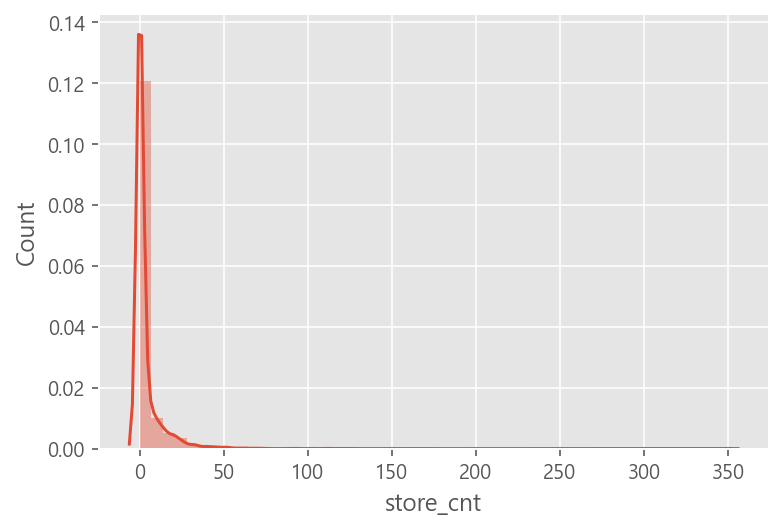

In [186]:
ax = sns.distplot(gangseo_pop_grid['store_cnt'])
ax.set_ylabel('Count')

In [187]:
# 강서구 전기차 충전소 불러오기 
gangseo_charge_list=pd.read_csv('data/gangseo_charge_list.csv', encoding='cp949')
gangseo_charge_list.head()

,Unnamed: 0,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동
0,12,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동
1,13,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동
2,23,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동
3,27,환경부(한국자동차환경협회),곰달래문화복지센터 공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 강서로5길 50 지상주차장,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.529060,126.848898,강서구 화곡8동
4,88,환경부(한국자동차환경협회),롯데마트 김포공항점,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,"서울특별시 강서구 하늘길 77, 지하주차장 1층 A-18구역(방화동 886)",24시간 이용가능,NaN,급속(50kW),주차비 30분 무료 후 30분당 1000원/노후화로 철거예정,37.562144,126.801570,강서구 공항동


In [197]:
# 강서구 전기차 충전소 전처리
gangseo_charge_place=gangseo_charge_list.drop_duplicates('주소').reset_index(drop=True)
gangseo_charge_place['geometry'] = gangseo_charge_place.apply(lambda gangseo_charge_place : Point(gangseo_charge_place['경도'], gangseo_charge_place['위도']), axis=1)
gangseo_charge_place_gpd = gpd.GeoDataFrame(gangseo_charge_place, geometry='geometry')
gangseo_charge_place_gpd.crs

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [199]:
gangseo_charge_place_gpd.crs = 'epsg:4326'
gangseo_charge_place_gpd=gangseo_charge_place_gpd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [203]:
# 강서구 이용자 제한 없는 전기차 충전소 위치 
nlimit_gangseo_charge_place_gpd = gangseo_charge_place_gpd[gangseo_charge_place_gpd['이용자 제한'].isna()==True].reset_index(drop=True)


In [204]:
# 격자내 전기차 충전소 위치
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_charge_place_gpd['geometry'])):
        if gangseo_charge_place_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자내 이용자 제한 없는 전기차 충전소 위치
def nlimit_count_grid(grid):
    cnt = 0
    for i in range(len(nlimit_gangseo_charge_place_gpd['geometry'])):
        if nlimit_gangseo_charge_place_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [205]:
# 격자내 전기차 충전소 위치

charge_place_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_place_cnt_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_place_grid.append(charge_place_cnt_grid)
gangseo_pop_grid['charge_place_cnt'] = charge_place_grid

In [206]:
# 격자내 이용자 제한없는 전기차 충전소 위치
nlimit_charge_place_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    nlimit_charge_place_cnt_grid=nlimit_count_grid(gangseo_pop_grid['geometry'][i])
    nlimit_charge_place_grid.append(nlimit_charge_place_cnt_grid)
gangseo_pop_grid['nlimit_charge_place_cnt'] = nlimit_charge_place_grid

In [216]:
# 전기차 충전소 대수 전처리
gangseo_charge_list['geometry'] = gangseo_charge_list.apply(lambda gangseo_charge_list : Point(gangseo_charge_list['경도'], gangseo_charge_list['위도']), axis=1)
gangseo_charge_list_gpd = gpd.GeoDataFrame(gangseo_charge_list, geometry='geometry')
gangseo_charge_list_gpd.head()

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,Unnamed: 0,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동,geometry
0,12,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동,POINT (126.83704 37.53723)
1,13,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동,POINT (126.86373 37.56198)
2,23,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동,POINT (126.85058 37.55967)
3,27,환경부(한국자동차환경협회),곰달래문화복지센터 공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 강서로5길 50 지상주차장,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.529060,126.848898,강서구 화곡8동,POINT (126.84890 37.52906)
4,88,환경부(한국자동차환경협회),롯데마트 김포공항점,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,"서울특별시 강서구 하늘길 77, 지하주차장 1층 A-18구역(방화동 886)",24시간 이용가능,NaN,급속(50kW),주차비 30분 무료 후 30분당 1000원/노후화로 철거예정,37.562144,126.801570,강서구 공항동,POINT (126.80157 37.56214)


In [222]:
gangseo_charge_list_gpd.crs = 'epsg:4326'
gangseo_charge_list_gpd=gangseo_charge_list_gpd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [226]:
# 이용자 제한 없는 전기차 충전소 대수 
nlimit_gangseo_charge_list_gpd = gangseo_charge_list_gpd[gangseo_charge_list_gpd['이용자 제한'].isna()==True].reset_index(drop=True)

In [228]:
# 격자내 전기차 충전소 대수
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_charge_list_gpd['geometry'])):
        if gangseo_charge_list_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

# 격자내 이용자 제한 없는 전기차 충전소 대수
def nlimit_count_grid(grid):
    cnt = 0
    for i in range(len(nlimit_gangseo_charge_list_gpd['geometry'])):
        if nlimit_gangseo_charge_list_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [229]:
# 격자내 전기차 충전소 대수

charge_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_list_cnt_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_cnt_grid.append(charge_list_cnt_grid)
gangseo_pop_grid['charge_list_cnt'] = charge_cnt_grid

In [230]:
# 이용자 제한 없는 전기차 충전소 대수

nlimit_charge_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    nlimit_charge_list_cnt_grid=nlimit_count_grid(gangseo_pop_grid['geometry'][i])
    nlimit_charge_cnt_grid.append(nlimit_charge_list_cnt_grid)
gangseo_pop_grid['ncharge_list_cnt'] = nlimit_charge_cnt_grid

In [237]:
# pip install openpyxl
# 강서구 가로등 위치정보 전처리
gangseo_light=pd.read_excel('data/강서구 가로등 위치정보.xlsx', header=1)
gangseo_light['geometry'] = gangseo_light.apply(lambda gangseo_light : Point([gangseo_light['Y좌표'], gangseo_light['X좌표']]), axis=1)
gangseo_light_gpd = gpd.GeoDataFrame(gangseo_light, geometry='geometry')
gangseo_light_gpd.crs = 'epsg:4326'
gangseo_light_gpd = gangseo_light_gpd.to_crs({'init':'epsg:5179'})
gangseo_light_gpd.head()

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,연번,관리번호,읍면,리,주소,새주소,X좌표,Y좌표,geometry
0,1,(수)양천로1,NaN,NaN,NaN,NaN,37.571188,126.836042,POINT (941368.163 1952631.300)
1,2,(수)양천로10,NaN,NaN,NaN,NaN,37.569694,126.838703,POINT (941601.940 1952463.864)
2,3,(수)양천로11,NaN,NaN,NaN,NaN,37.569532,126.839015,POINT (941629.334 1952445.724)
3,4,(수)양천로2,NaN,NaN,NaN,NaN,37.571028,126.836312,POINT (941391.809 1952613.430)
4,5,(수)양천로27길10,NaN,NaN,NaN,NaN,37.575472,126.820145,POINT (939967.730 1953116.587)


In [241]:
# 격자내 가로등의 갯수
def count_grid(grid):
    cnt = 0
    for i in range(len(gangseo_light_gpd['geometry'])):
        if gangseo_light_gpd['geometry'][i].within(grid) == True:
            cnt+=1
        else:
            pass
    return cnt

In [242]:
# 격자내 가로등의 갯수

charge_light_cnt_grid = []
for i in range(len(gangseo_pop_grid['geometry'])):
    charge_light_grid=count_grid(gangseo_pop_grid['geometry'][i])
    charge_light_cnt_grid.append(charge_light_grid)
gangseo_pop_grid['light'] = charge_light_cnt_grid

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='light', ylabel='Density'>

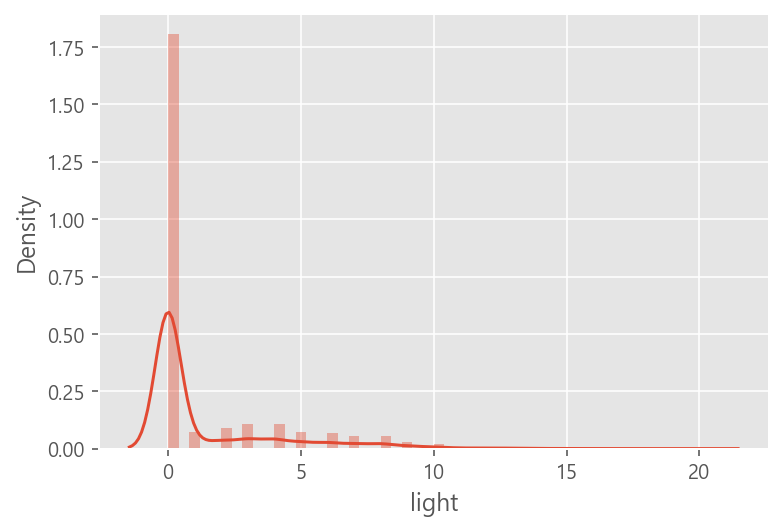

In [243]:
sns.distplot(gangseo_pop_grid['light'])

In [244]:
#pip install xlrd
# https://data.seoul.go.kr/dataList/10043/S/2/datasetView.do
# 서울시 주민등록인구 (동별) 통계 2021년 기준
seoul_hdong_population=pd.read_excel('data/Seoul_hdong_population.xls', usecols=[1,2,4], header=1)
gangseo_hdong_population=seoul_hdong_population[seoul_hdong_population['자치구'] == '강서구'].reset_index(drop=True).loc[1:, '동':]
gangseo_hdong_population.columns = ['행정동사용본거지', '인구합계']
gangseo_hdong_population.head()

,행정동사용본거지,인구합계
1,염창동,41764
2,등촌1동,24436
3,등촌2동,20423
4,등촌3동,30714
5,화곡본동,34612


In [245]:
# http://data.seoul.go.kr/dataList/OA-21236/F/1/datasetView.do
# 연월 2021년 12월 기준
# 동별 전기차수 
elecar_hdong_list=pd.read_csv('data/15_21년 행정동별 연료별 자동차 등록현황.csv', header=1, encoding='cp949')
gangseo_elecar_hdong_list=elecar_hdong_list[(elecar_hdong_list['연월']== 202112) & (elecar_hdong_list['사용본거지시군구']=='서울특별시 강서구') & (elecar_hdong_list['연료']=='전기')]
gangseo_elecar_hdong_list = gangseo_elecar_hdong_list.groupby('행정동사용본거지')['건수'].sum().reset_index()
gangseo_elecar_hdong_list['행정동사용본거지']=gangseo_elecar_hdong_list['행정동사용본거지'].apply(lambda x: re.findall('(\w+)', x)[2])
gangseo_elecar_hdong_list.columns = ['행정동사용본거지', '전기차수']
gangseo_elecar_hdong_list.head()

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,행정동사용본거지,전기차수
0,가양1동,449
1,가양2동,23
2,가양3동,32
3,공항동,166
4,등촌1동,66


In [246]:
gangseo_elecar_pop=pd.merge(gangseo_elecar_hdong_list, gangseo_hdong_population, how = 'left', on = '행정동사용본거지')
gangseo_elecar_pop['전기차/인구비율'] = gangseo_elecar_pop['전기차수'] / gangseo_elecar_pop['인구합계']
gangseo_elecar_pop.head()

,행정동사용본거지,전기차수,인구합계,전기차/인구비율
0,가양1동,449,34395,0.013054
1,가양2동,23,14109,0.00163
2,가양3동,32,15138,0.002114
3,공항동,166,31483,0.005273
4,등촌1동,66,24436,0.002701


<AxesSubplot:xlabel='전기차/인구비율', ylabel='행정동사용본거지'>

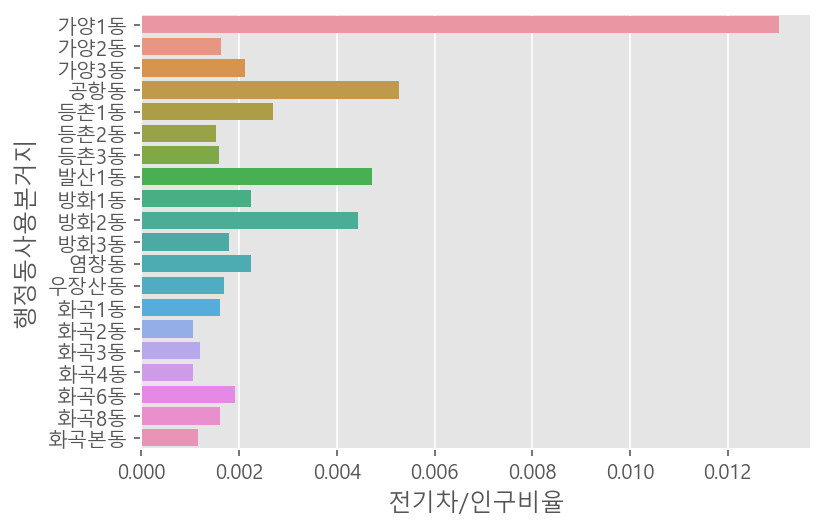

In [247]:
sns.barplot(x='전기차/인구비율', y='행정동사용본거지', data=gangseo_elecar_pop)

In [250]:
gangseo_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [253]:
# 좌표게 WGS84 (EPSG:4326)
# 행정동 좌표계
gangseo_boundary=gpd.read_file('data/gangseohdong.shp', encoding='UTF-8')
gangseo_boundary=gangseo_boundary.to_crs(epsg=5179)
gangseo_boundary.head()

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,temp,sggnm,adm_cd8,geometry
0,241,서울특별시 강서구 염창동,1116051,1150051000,11500,11,서울특별시,강서구 염창동,강서구,11160510,"POLYGON ((943908.633 1950365.885, 943917.099 1..."
1,242,서울특별시 강서구 등촌1동,1116052,1150052000,11500,11,서울특별시,강서구 등촌1동,강서구,11160520,"POLYGON ((943741.125 1951027.375, 943833.188 1..."
2,243,서울특별시 강서구 등촌2동,1116053,1150053000,11500,11,서울특별시,강서구 등촌2동,강서구,11160530,"POLYGON ((943847.313 1950417.500, 943724.524 1..."
3,244,서울특별시 강서구 등촌3동,1116054,1150053500,11500,11,서울특별시,강서구 등촌3동,강서구,11160540,"POLYGON ((942492.188 1951870.625, 943050.133 1..."
4,245,서울특별시 강서구 화곡본동,1116055,1150059000,11500,11,서울특별시,강서구 화곡본동,강서구,11160550,"POLYGON ((943008.500 1949835.875, 943013.750 1..."


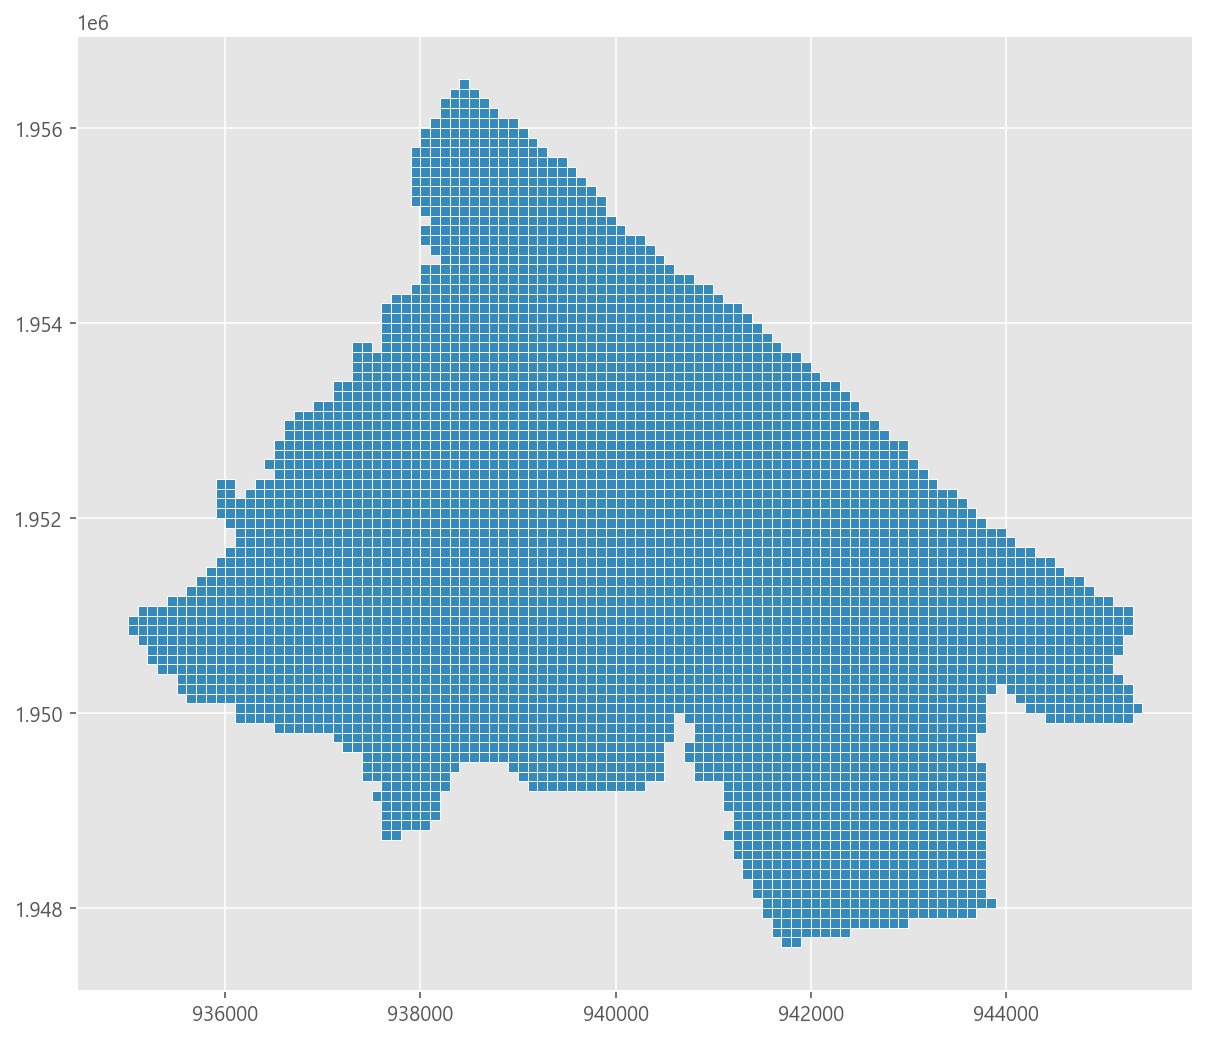

In [254]:
ax = gangseo_pop_grid.plot(edgecolor='white', figsize=(10, 10))
plt.show()

In [256]:
gangseo_pop_grid

,gid,lbl,val,geometry,store_cnt,charge_place_cnt,nlimit_charge_place_cnt,charge_list_cnt,ncharge_list_cnt,light
0,다사404502,289,289,"POLYGON ((940400.000 1950200.000, 940400.000 1...",2,2,0,7,0,7
1,다사436483,217,217,"POLYGON ((943600.000 1948300.000, 943600.000 1...",30,0,0,0,0,1
2,다사391528,46,46,"POLYGON ((939100.000 1952800.000, 939100.000 1...",25,0,0,0,0,10
3,다사400518,615,615,"POLYGON ((940000.000 1951800.000, 940000.000 1...",3,0,0,0,0,1
4,다사402503,646,646,"POLYGON ((940200.000 1950300.000, 940200.000 1...",3,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
4377,다사379488,0,0,"POLYGON ((937900.000 1948800.000, 937900.000 1...",0,0,0,0,0,0
4378,다사410509,0,0,"POLYGON ((941000.000 1950900.000, 941000.000 1...",0,0,0,0,0,4
4379,다사378491,0,0,"POLYGON ((937800.000 1949100.000, 937800.000 1...",0,0,0,0,0,0
4380,다사398539,0,0,"POLYGON ((939800.000 1953900.000, 939800.000 1...",0,0,0,0,0,3


In [257]:
# within을 사용해서 행정동경계에 grid가 포함되면 소속 행정동 반환
def pop_grid_hdong(grid):
    for i in range(len(gangseo_boundary['geometry'])):
        if grid.within(gangseo_boundary['geometry'][i]) == True:
            hdong_name = gangseo_boundary['adm_nm'][i]
            return hdong_name
        else:
            pass

In [258]:
grid_hdong = []
for i in range(len(gangseo_pop_grid['geometry'])):
    grid_in_hdong=pop_grid_hdong(gangseo_pop_grid['geometry'][i])
    grid_hdong.append(grid_in_hdong)
gangseo_pop_grid['hdong'] = grid_hdong

In [259]:
gangseo_pop_grid

,gid,lbl,val,geometry,store_cnt,charge_place_cnt,nlimit_charge_place_cnt,charge_list_cnt,ncharge_list_cnt,light,hdong
0,다사404502,289,289,"POLYGON ((940400.000 1950200.000, 940400.000 1...",2,2,0,7,0,7,서울특별시 강서구 발산1동
1,다사436483,217,217,"POLYGON ((943600.000 1948300.000, 943600.000 1...",30,0,0,0,0,1,서울특별시 강서구 화곡4동
2,다사391528,46,46,"POLYGON ((939100.000 1952800.000, 939100.000 1...",25,0,0,0,0,10,None
3,다사400518,615,615,"POLYGON ((940000.000 1951800.000, 940000.000 1...",3,0,0,0,0,1,서울특별시 강서구 방화1동
4,다사402503,646,646,"POLYGON ((940200.000 1950300.000, 940200.000 1...",3,0,0,0,0,4,서울특별시 강서구 발산1동
...,...,...,...,...,...,...,...,...,...,...,...
4377,다사379488,0,0,"POLYGON ((937900.000 1948800.000, 937900.000 1...",0,0,0,0,0,0,None
4378,다사410509,0,0,"POLYGON ((941000.000 1950900.000, 941000.000 1...",0,0,0,0,0,4,서울특별시 강서구 발산1동
4379,다사378491,0,0,"POLYGON ((937800.000 1949100.000, 937800.000 1...",0,0,0,0,0,0,서울특별시 강서구 공항동
4380,다사398539,0,0,"POLYGON ((939800.000 1953900.000, 939800.000 1...",0,0,0,0,0,3,서울특별시 강서구 방화3동


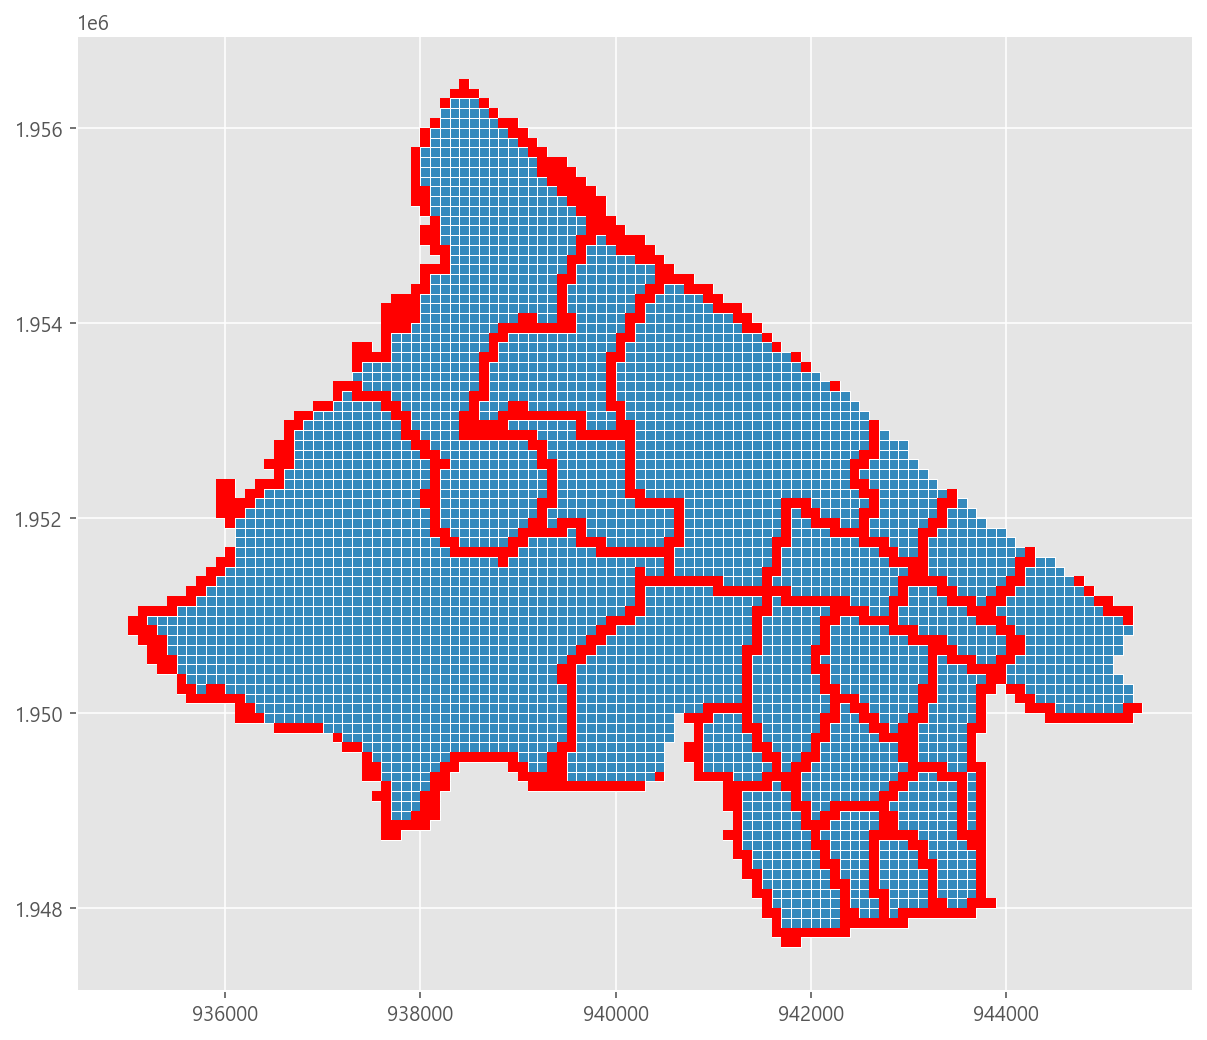

In [260]:
ax = gangseo_pop_grid.plot(edgecolor='white', figsize=(10, 10))
gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].plot(color = 'red', ax = ax)
plt.show()

In [97]:
gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].shape

(916, 11)

In [262]:
def max_area_hdong(dict_cal):
    print(dict_cal)
    max_area_name=dict_cal[max(dict_cal.keys())]
    print(max_area_name)
    return max_area_name
    

In [263]:
def grid_intersection(grid):  # polygon 들어가면
    intersection_area = []  # 리스트 지정  이름
    area_hdong_name = [] # 리스트 지정  면적 
    for i in range(len(gangseo_boundary['geometry'])):   # 행정동 구역 돌리기      
        inter_area = grid.intersection(gangseo_boundary['geometry'][i]).area #len만큼 반복하면서 area의 값을 inter_area에 저장
        if inter_area > 0:  # 0보다 크다면 
            area_hdong_name.append(gangseo_boundary['adm_nm'][i]) # 이름 추가하기 
            intersection_area.append(inter_area) # area추가하기 
        else:
            area_hdong_name.append('0')
            intersection_area.append(0)
            
    dict_cal = dict(zip(intersection_area, area_hdong_name)) # dictionary로 묶기  행정동이름 면적
    hdong=max_area_hdong(dict_cal) # max_area_hdong 함수 호출
    return hdong # max_area_hdong을 마친 hdong 최종 return 


In [264]:
# hdong을 구분하지 못한 hdong에 대해서 추출하기
na_index=gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].index
na_gangseo_pop_grid=gangseo_pop_grid[gangseo_pop_grid['hdong'].isna()==True].reset_index(drop=True)
na_gangseo_pop_grid.head()

na_grid_hdong = []
for i in range(len(na_gangseo_pop_grid['geometry'])):    # geometry의 범위만큼 들어감  127, 36
    final_name=grid_intersection(na_gangseo_pop_grid['geometry'][i]) # grid_intersection 함수에 Polygon 들어간다.
    na_grid_hdong.append(final_name)
gangseo_pop_grid.loc[na_index, 'hdong'] = na_grid_hdong

{0: '0', 5975.343240373882: '서울특별시 강서구 방화1동', 4024.6567596261193: '서울특별시 강서구 방화2동'}
서울특별시 강서구 방화1동
{0: '0', 556.1686143801057: '서울특별시 강서구 발산1동', 9443.831385619895: '서울특별시 강서구 우장산동'}
서울특별시 강서구 우장산동
{0: '0', 8548.901800834574: '서울특별시 강서구 화곡3동'}
서울특별시 강서구 화곡3동
{0: '0', 7953.126321511809: '서울특별시 강서구 화곡4동'}
서울특별시 강서구 화곡4동
{0: '0', 8386.943908381145: '서울특별시 강서구 화곡본동', 1613.0560916188556: '서울특별시 강서구 화곡6동'}
서울특별시 강서구 화곡본동
{0: '0', 1193.8387461893847: '서울특별시 강서구 화곡1동'}
서울특별시 강서구 화곡1동
{0: '0', 7493.4530029599055: '서울특별시 강서구 방화1동', 2506.546997040095: '서울특별시 강서구 방화2동'}
서울특별시 강서구 방화1동
{0: '0', 7936.11787727283: '서울특별시 강서구 등촌1동', 2063.88212272717: '서울특별시 강서구 등촌2동'}
서울특별시 강서구 등촌1동
{0: '0', 1004.4788663640296: '서울특별시 강서구 발산1동', 8995.521133635972: '서울특별시 강서구 공항동'}
서울특별시 강서구 공항동
{0: '0', 6657.417692408447: '서울특별시 강서구 화곡8동', 3342.582307591553: '서울특별시 강서구 화곡1동'}
서울특별시 강서구 화곡8동
{0: '0', 1722.584961022244: '서울특별시 강서구 등촌2동', 8277.415038977757: '서울특별시 강서구 화곡4동'}
서울특별시 강서구 화곡4동
{0: '0', 6731.897340388969: '서울특

In [265]:
gangseo_pop_grid[gangseo_pop_grid['hdong']=='0'].shape

(51, 11)

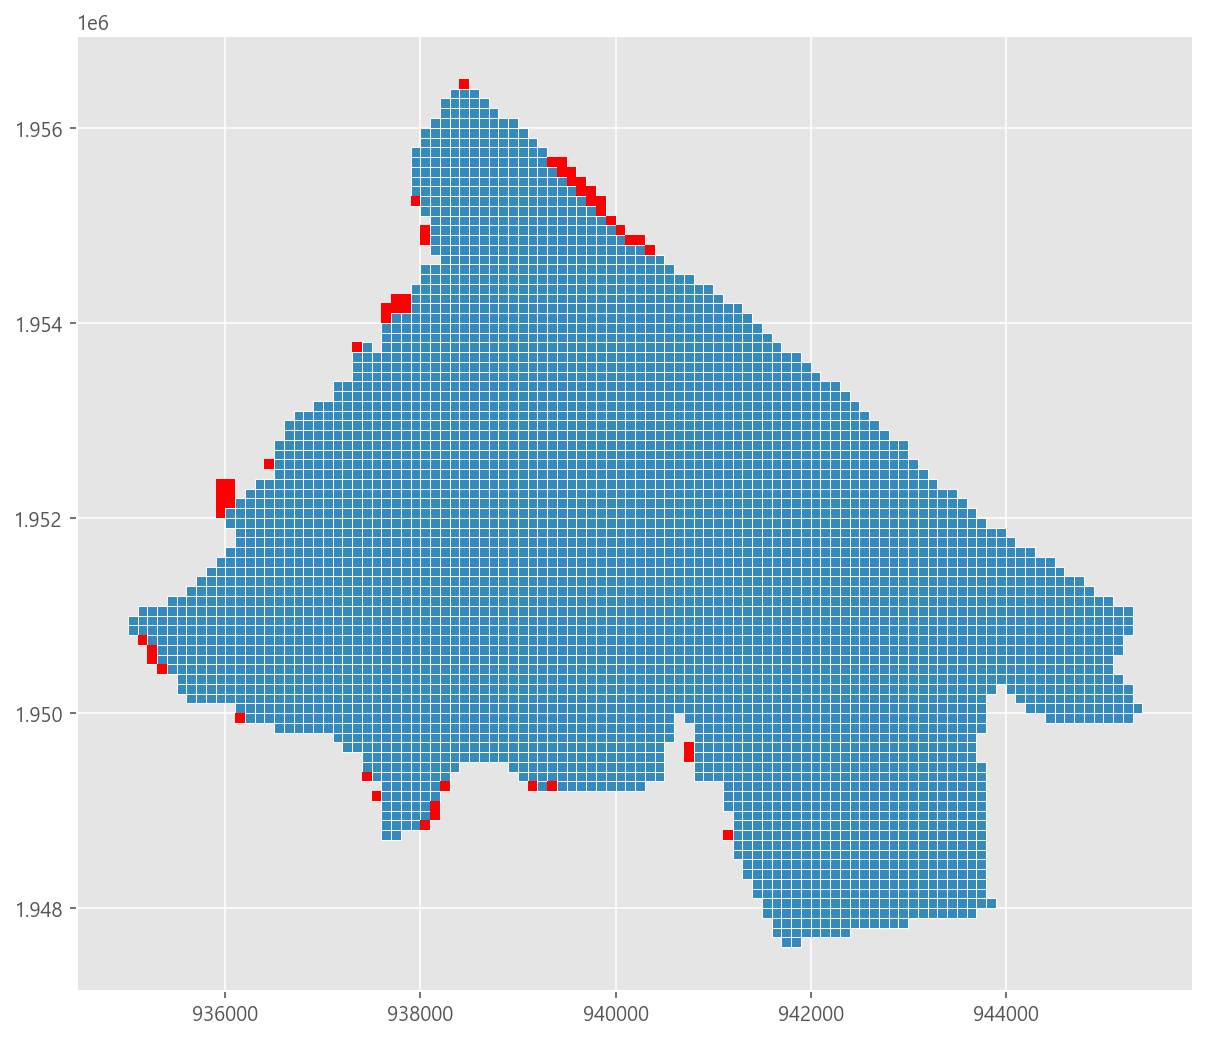

In [266]:
ax = gangseo_pop_grid.plot(edgecolor='white', figsize=(10, 10))
gangseo_pop_grid[gangseo_pop_grid['hdong']=='0'].plot(color = 'red', ax = ax)
plt.show()

In [267]:
def most_frequent(data):
    if len(data)!=0:
        max_name = max(data, key=data.count)
    else:
        max_name = '0'
    return max_name


In [268]:
def find_intersect(grid):
    intersect_name = []
    for j in range(len(gangseo_pop_grid['geometry'])):
        if grid.intersects(gangseo_pop_grid['geometry'][j])==True:
            if gangseo_pop_grid['hdong'][j] !='0':
                intersect_name.append(gangseo_pop_grid['hdong'][j])
            else:
                pass
        else:
            pass
        
    pre_hdong_name= most_frequent(intersect_name)
    
    return pre_hdong_name

In [269]:
cnt = 0
while cnt <5:
    unknown_hdong=gangseo_pop_grid[gangseo_pop_grid['hdong']=='0']
    prd_intersect_name = []
    for i in unknown_hdong['geometry']:
        prd_hdong=find_intersect(i)
        prd_intersect_name.append(prd_hdong)
    na_index = unknown_hdong.index
    gangseo_pop_grid.loc[na_index, 'hdong'] = prd_intersect_name
    unknown_grid_hdong = gangseo_pop_grid[gangseo_pop_grid['hdong']=='0'].shape[0]
    print(f'{cnt+1}번 실행시 예측 못한 행정동은 {unknown_grid_hdong}입니다')
    cnt+=1


1번 실행시 예측 못한 행정동은 4입니다
2번 실행시 예측 못한 행정동은 0입니다
3번 실행시 예측 못한 행정동은 0입니다
4번 실행시 예측 못한 행정동은 0입니다
5번 실행시 예측 못한 행정동은 0입니다


In [270]:
# gangseo_pop_grid 행정동 전처리 하기 
gangseo_pop_grid['hdong']=gangseo_pop_grid['hdong'].apply(lambda x : re.findall('(\w+)', x)[2])

In [272]:
# 행정동별 전기차 / 인구수 비율
check_list = []
for i in range(len(gangseo_pop_grid['hdong'])):
    for j in range(len(gangseo_elecar_pop['전기차/인구비율'])):
        if gangseo_pop_grid['hdong'][i] == gangseo_elecar_pop['행정동사용본거지'][j]:
            check_list.append(gangseo_elecar_pop['전기차/인구비율'][j])
        else:
            pass
gangseo_pop_grid['elecar_pop_per'] = check_list
gangseo_pop_grid['predict_elecar'] = gangseo_pop_grid['val'] * gangseo_pop_grid['elecar_pop_per'] # 격자내 인구수 * 전기차/인구비율
gangseo_pop_grid['predict_elecar']= round(gangseo_pop_grid['predict_elecar']) 

In [273]:
predict_dong_elec=gangseo_pop_grid.groupby('hdong')['predict_elecar'].sum().reset_index()
predict_dong_elec.columns = ['행정동사용본거지', 'predict_elecar']

In [274]:
sumlist = ['sum', gangseo_prdictreal_elecar['전기차수'].sum(), gangseo_prdictreal_elecar['predict_elecar'].sum(),
           gangseo_prdictreal_elecar['전기차수'].sum() / gangseo_prdictreal_elecar['predict_elecar'].sum() * 100]


In [275]:
gangseo_prdictreal_elecar=pd.merge(gangseo_elecar_hdong_list, predict_dong_elec, how='left', on = '행정동사용본거지')
gangseo_prdictreal_elecar['pred_real_per'] = gangseo_prdictreal_elecar['predict_elecar'] / gangseo_prdictreal_elecar['전기차수'] *100
sumlist = ['sum', gangseo_prdictreal_elecar['전기차수'].sum(), gangseo_prdictreal_elecar['predict_elecar'].sum(),
           gangseo_prdictreal_elecar['전기차수'].sum() / gangseo_prdictreal_elecar['predict_elecar'].sum() * 100]
gangseo_prdictreal_elecar.sort_values('pred_real_per', ascending=False,inplace=True)
gangseo_prdictreal_elecar.loc[20] = sumlist
gangseo_prdictreal_elecar

,행정동사용본거지,전기차수,predict_elecar,pred_real_per
19,화곡본동,40,46.0,115.000000
5,등촌2동,31,33.0,106.451613
13,화곡1동,85,90.0,105.882353
18,화곡8동,40,42.0,105.000000
15,화곡3동,26,27.0,103.846154
17,화곡6동,48,49.0,102.083333
4,등촌1동,66,65.0,98.484848
6,등촌3동,49,48.0,97.959184
0,가양1동,449,438.0,97.550111
8,방화1동,97,94.0,96.907216


<AxesSubplot:xlabel='pred_real_per', ylabel='행정동사용본거지'>

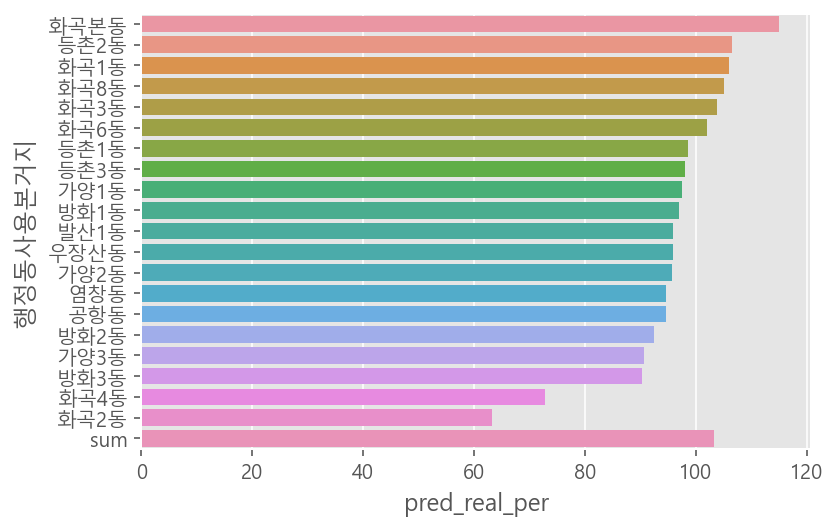

In [276]:
sns.barplot(x ='pred_real_per', y =  '행정동사용본거지', data=gangseo_prdictreal_elecar)

In [277]:
# 전체 전기차 충전소 위치
gangseo_charge_place_gpd.head()

,Unnamed: 0,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동,geometry
0,12,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동,POINT (941429.604 1948863.728)
1,13,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동,POINT (943806.447 1951593.341)
2,23,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동,POINT (942643.461 1951344.439)
3,27,환경부(한국자동차환경협회),곰달래문화복지센터 공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 강서로5길 50 지상주차장,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.529060,126.848898,강서구 화곡8동,POINT (942471.050 1947949.446)
4,88,환경부(한국자동차환경협회),롯데마트 김포공항점,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,"서울특별시 강서구 하늘길 77, 지하주차장 1층 A-18구역(방화동 886)",24시간 이용가능,NaN,급속(50kW),주차비 30분 무료 후 30분당 1000원/노후화로 철거예정,37.562144,126.801570,강서구 공항동,POINT (938316.551 1951649.991)


In [278]:
# 이용자 제한 없는 전기차 충전소 위치 
nlimit_gangseo_charge_place_gpd = gangseo_charge_place_gpd[gangseo_charge_place_gpd['이용자 제한'].isna()==True].reset_index(drop=True)
nlimit_gangseo_charge_place_gpd.head()

,Unnamed: 0,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동,geometry
0,12,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동,POINT (941429.604 1948863.728)
1,13,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동,POINT (943806.447 1951593.341)
2,23,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동,POINT (942643.461 1951344.439)
3,27,환경부(한국자동차환경협회),곰달래문화복지센터 공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 강서로5길 50 지상주차장,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.529060,126.848898,강서구 화곡8동,POINT (942471.050 1947949.446)
4,88,환경부(한국자동차환경협회),롯데마트 김포공항점,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,"서울특별시 강서구 하늘길 77, 지하주차장 1층 A-18구역(방화동 886)",24시간 이용가능,NaN,급속(50kW),주차비 30분 무료 후 30분당 1000원/노후화로 철거예정,37.562144,126.801570,강서구 공항동,POINT (938316.551 1951649.991)


In [279]:
gangseo_pop_grid['geometry'].loc[0].distance(gangseo_charge_place_gpd['geometry'].loc[0])

1627.8167277620234

In [280]:
# 최소 거리 계산
def near_dist_cal(data_list):
    return min(data_list)

In [281]:
# 전체 전기차 충전소 위치 거리 계산
def dist_cal(grid):
    near_dist_list = []
    for i in range(len(gangseo_charge_place_gpd['geometry'])):
        cal_dist = grid.distance(gangseo_charge_place_gpd['geometry'][i])
        if cal_dist >0:
            near_dist_list.append(cal_dist)
        else:
            pass
    
    min_dist=near_dist_cal(near_dist_list)
    return min_dist
# 이용자 제한 없는 전기차 충전소 위치 거리 계산
def nlimit_dist_cal(grid):
    nlimit_near_dist_list = []
    for i in range(len(nlimit_gangseo_charge_place_gpd['geometry'])):
        nlimit_cal_dist = grid.distance(nlimit_gangseo_charge_place_gpd['geometry'][i])
        if nlimit_cal_dist >0:
            nlimit_near_dist_list.append(nlimit_cal_dist)
        else:
            pass
    
    nlimit_min_dist=near_dist_cal(nlimit_near_dist_list)
    return nlimit_min_dist

In [282]:
# 전체 천기차 충전소 위치 거리
dist_list = []
for i in gangseo_pop_grid['geometry']:
    dist=dist_cal(i)
    dist_list.append(dist)

gangseo_pop_grid['near_dist'] = dist_list
    

In [284]:
# 이용자 제한 없는 전기차 충전소
nlimit_dist_list = []
for i in gangseo_pop_grid['geometry']:
    dist= nlimit_dist_cal(i)
    nlimit_dist_list.append(dist)

gangseo_pop_grid['nlimit_near_dist'] = nlimit_dist_list

In [348]:
gangseo_pop_grid['nlimit_near_dist'].reset_index()

,index,nlimit_near_dist
0,0,199.724009
1,1,334.232759
2,2,142.911205
3,3,196.573544
4,4,107.190559
...,...,...
4377,4377,1048.091511
4378,4378,204.683854
4379,4379,742.576251
4380,4380,400.324563


In [350]:
gangseo_pop_grid.head()

,gid,lbl,val,geometry,store_cnt,charge_place_cnt,nlimit_charge_place_cnt,charge_list_cnt,ncharge_list_cnt,light,hdong,elecar_pop_per,predict_elecar,near_dist,nlimit_near_dist,traffic,bd_cnt
0,다사404502,289,289,"POLYGON ((940400.000 1950200.000, 940400.000 1...",2,2,0,7,0,7,발산1동,0.004730,1.0,193.286924,199.724009,9922,0
1,다사436483,217,217,"POLYGON ((943600.000 1948300.000, 943600.000 1...",30,0,0,0,0,1,화곡4동,0.001057,0.0,334.232759,334.232759,21090,0
2,다사391528,46,46,"POLYGON ((939100.000 1952800.000, 939100.000 1...",25,0,0,0,0,10,방화1동,0.002246,0.0,116.421827,142.911205,5702,0
3,다사400518,615,615,"POLYGON ((940000.000 1951800.000, 940000.000 1...",3,0,0,0,0,1,방화1동,0.002246,1.0,128.661956,196.573544,5702,0
4,다사402503,646,646,"POLYGON ((940200.000 1950300.000, 940200.000 1...",3,0,0,0,0,4,발산1동,0.004730,3.0,107.190559,107.190559,9922,0


In [347]:
gangseo_pop_grid['nlimit_near_dist']

,index,nlimit_near_dist
0,0,199.724009
1,1,334.232759
2,2,142.911205
3,3,196.573544
4,4,107.190559
...,...,...
4377,4377,1048.091511
4378,4378,204.683854
4379,4379,742.576251
4380,4380,400.324563


C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='nlimit_near_dist', ylabel='Density'>

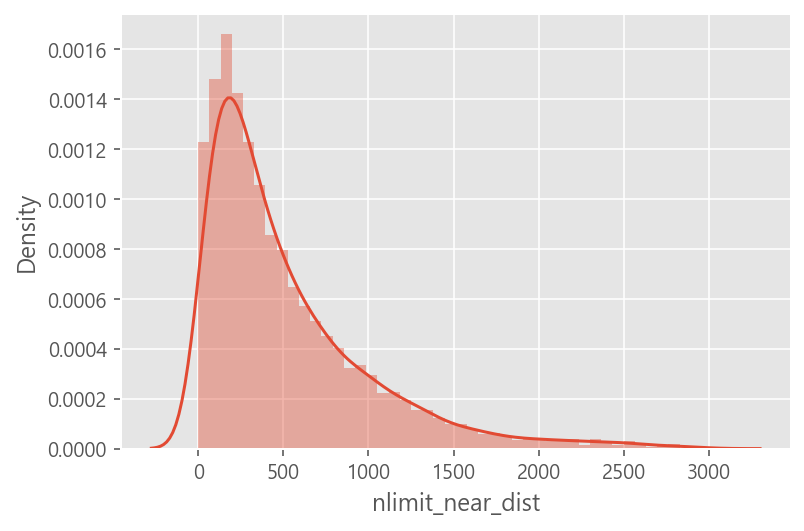

In [286]:
sns.distplot(gangseo_pop_grid['nlimit_near_dist'])

In [143]:
#cctv_gangseo=pd.read_csv('data/서울특별시 강서구 (안심이) CCTV 설치 현황.csv', encoding='cp949')

In [146]:
#cctv_gangseo.head()

,자치구,안심 주소,CCTV 용도,위도,경도,CCTV 수량,수정 일시
0,강서구,P253001(A5002)_화곡1동 908-9(호돌이 공원),도심공원,37.528107,126.845980,1,2021-01-29
1,강서구,P303005_화곡8동 892-17(모태어린이공원),도심공원,37.529472,126.849621,1,2021-01-29
2,강서구,P263002_화곡2동 883-3 하마터어린이공원,도심공원,37.529998,126.853446,1,2021-01-29
3,강서구,P263001_화곡2동 845-19 뜸부기어린이공원,도심공원,37.530087,126.856926,1,2021-01-29
4,강서구,P253005_화곡1동 355-12(필마어린이공원),도심공원,37.531600,126.838757,1,2021-01-29


In [147]:
#cctv_gangseo['geometry'] = cctv_gangseo.apply(lambda cctv_gangseo : Point([cctv_gangseo['경도'], cctv_gangseo['위도']]), axis=1)

#cctv_gangseo_gpd = gpd.GeoDataFrame(cctv_gangseo, geometry='geometry')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [149]:
# 격자 별 CCTV 갯수 계산
# def count_grid(grid):
#     cnt = 0
#     for i in range(len(cctv_gangseo_gpd['geometry'])):
#         if cctv_gangseo_gpd['geometry'][i].within(grid) == True:
#             cnt+=1
#         else:
#             pass
#     return cnt

In [158]:
# 격자 별 cctv 계산하여 cctv_cnt로 추가하기 
# cctv_grid = []
# for i in range(len(gangseo_pop_grid['geometry'])):
#     cctv_grid_cnt=count_grid(gangseo_pop_grid['geometry'][i])
#     cctv_grid.append(cctv_grid_cnt)
# gangseo_pop_grid['cctv_cnt'] = cctv_grid

In [160]:
# gangseo_pop_grid['cctv_cnt']

0        2
1       30
2       25
3        3
4        3
        ..
4377     0
4378     0
4379     0
4380     0
4381     0
Name: cctv_cnt, Length: 4382, dtype: int64

In [297]:
traffic=pd.read_csv('data/2018년_추정교통량_행정구역_읍면동단위.csv')

In [298]:
gangseo_traffic=traffic[traffic['sigungu_code'] ==11160]
gangseo_traffic.reset_index(drop=True, inplace=True)
gangseo_traffic.head()

,sido_code,sigungu_code,emd_code,week_type,ALL_AADT,PSCR_AADT,BUS_AADT,FGCR_AADT
0,11,11160,1116063,weekday,14379,11253,104,3021
1,11,11160,1116074,weekday,6724,5329,40,1356
2,11,11160,1116052,weekday,15462,12326,116,3019
3,11,11160,1116061,weekday,8983,7136,58,1788
4,11,11160,1116051,weekday,19468,15057,381,4030


In [299]:
h_code = pd.read_excel('data/adm_code.xls', header=1)
h_code['시도코드']=h_code['시도코드'].apply(lambda x : str(x))
h_code['시군구코드'] = h_code['시군구코드'].apply(lambda x: str(x))
h_code['읍면동코드'] = h_code['읍면동코드'].apply(lambda x : str(x))
h_code['코드'] = h_code['시도코드']+h_code['시군구코드']+h_code['읍면동코드']
h_code=h_code.astype({'코드':'int'})
h_code.head()

,시도코드,시도명칭,시군구코드,시군구명칭,읍면동코드,읍면동명칭,코드
0,11,서울특별시,10,종로구,53,사직동,111053
1,11,서울특별시,10,종로구,54,삼청동,111054
2,11,서울특별시,10,종로구,55,부암동,111055
3,11,서울특별시,10,종로구,56,평창동,111056
4,11,서울특별시,10,종로구,57,무악동,111057


In [300]:

hdong_list = []
for i in range(len(gangseo_traffic['emd_code'])):
    for j in range(len(h_code['코드'])):
        if gangseo_traffic['emd_code'][i]==h_code['코드'][j]:
            hdong_list.append(h_code['읍면동명칭'][j])
            
gangseo_traffic['hdong'] = hdong_list
# ALL_AADT : 전체 교통량, PSCR_AADT : 차량 교통량
gangseo_traffic=gangseo_traffic[['ALL_AADT', 'hdong']]
gangseo_traffic=gangseo_traffic.sort_values('ALL_AADT', ascending=False).reset_index(drop=True)
gangseo_traffic

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,ALL_AADT,hdong
0,25031,가양2동
1,21674,화곡2동
2,21090,화곡4동
3,19468,염창동
4,18710,방화2동
5,15462,등촌1동
6,14379,화곡8동
7,12428,화곡본동
8,11528,화곡1동
9,10769,가양1동


<AxesSubplot:xlabel='ALL_AADT', ylabel='hdong'>

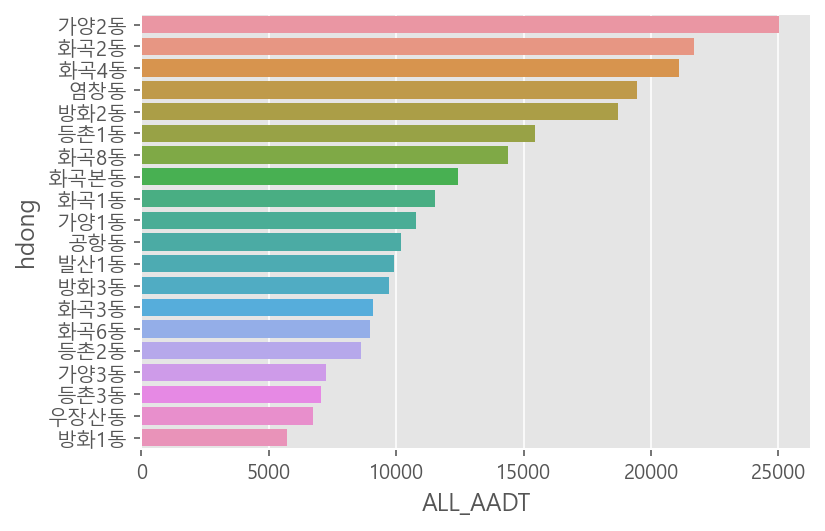

In [302]:
sns.barplot(x = 'ALL_AADT', y = 'hdong', data = gangseo_traffic)

In [303]:

grid_hdong_traffic = []
for i in range(len(gangseo_pop_grid['hdong'])):
    for j in range(len(gangseo_traffic['hdong'])):
        if gangseo_pop_grid['hdong'][i]==gangseo_traffic['hdong'][j]:
            grid_hdong_traffic.append(gangseo_traffic['ALL_AADT'][j])
        else:
            pass
gangseo_pop_grid['traffic'] = grid_hdong_traffic

In [304]:
gangseo_pop_grid['traffic']

0        9922
1       21090
2        5702
3        5702
4        9922
        ...  
4377    10189
4378     9922
4379    10189
4380     9731
4381    10189
Name: traffic, Length: 4382, dtype: int64

In [305]:
gangseo_pop_grid

,gid,lbl,val,geometry,store_cnt,charge_place_cnt,nlimit_charge_place_cnt,charge_list_cnt,ncharge_list_cnt,light,hdong,elecar_pop_per,predict_elecar,near_dist,nlimit_near_dist,traffic
0,다사404502,289,289,"POLYGON ((940400.000 1950200.000, 940400.000 1...",2,2,0,7,0,7,발산1동,0.004730,1.0,193.286924,199.724009,9922
1,다사436483,217,217,"POLYGON ((943600.000 1948300.000, 943600.000 1...",30,0,0,0,0,1,화곡4동,0.001057,0.0,334.232759,334.232759,21090
2,다사391528,46,46,"POLYGON ((939100.000 1952800.000, 939100.000 1...",25,0,0,0,0,10,방화1동,0.002246,0.0,116.421827,142.911205,5702
3,다사400518,615,615,"POLYGON ((940000.000 1951800.000, 940000.000 1...",3,0,0,0,0,1,방화1동,0.002246,1.0,128.661956,196.573544,5702
4,다사402503,646,646,"POLYGON ((940200.000 1950300.000, 940200.000 1...",3,0,0,0,0,4,발산1동,0.004730,3.0,107.190559,107.190559,9922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,다사379488,0,0,"POLYGON ((937900.000 1948800.000, 937900.000 1...",0,0,0,0,0,0,공항동,0.005273,0.0,1048.091511,1048.091511,10189
4378,다사410509,0,0,"POLYGON ((941000.000 1950900.000, 941000.000 1...",0,0,0,0,0,4,발산1동,0.004730,0.0,204.683854,204.683854,9922
4379,다사378491,0,0,"POLYGON ((937800.000 1949100.000, 937800.000 1...",0,0,0,0,0,0,공항동,0.005273,0.0,742.576251,742.576251,10189
4380,다사398539,0,0,"POLYGON ((939800.000 1953900.000, 939800.000 1...",0,0,0,0,0,3,방화3동,0.001789,0.0,399.752314,400.324563,9731


In [316]:
# 좌표게 WGS84 (EPSG:4326)
# 행정동 좌표계
seoul_bd=gpd.read_file('data/서울특별시_길단위_발달상권/01_서울특별시_길단위_발달상권.shp', encoding='UTF-8')
seoul_bd.head()

,MEGA_CD,MEGA_NM,RD_NM,SG_FLG,geometry
0,11,서울특별시,419로_0,None,"LINESTRING (313206.699 561112.606, 313190.590 ..."
1,11,서울특별시,419로_1,None,"LINESTRING (313112.597 561085.605, 313087.802 ..."
2,11,서울특별시,419로_2,None,"LINESTRING (313076.876 561074.364, 313076.844 ..."
3,11,서울특별시,419로_3,None,"LINESTRING (312871.849 561013.531, 312851.486 ..."
4,11,서울특별시,419로_4,None,"LINESTRING (312778.263 560985.396, 312772.288 ..."


In [317]:
seoul_bd=seoul_bd.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

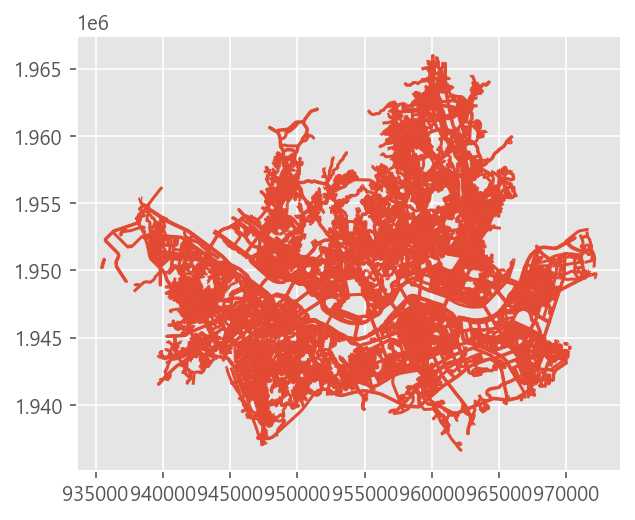

In [323]:
seoul_bd.plot()

In [324]:
f_seoul_bd=seoul_bd[seoul_bd['SG_FLG']=='발달'].reset_index(drop=True)
f_seoul_bd.head()

,MEGA_CD,MEGA_NM,RD_NM,SG_FLG,geometry
0,11,서울특별시,가락로_4,발달,"LINESTRING (965042.571 1944237.579, 965046.682..."
1,11,서울특별시,가락로_5,발달,"LINESTRING (965179.464 1944291.796, 965190.409..."
2,11,서울특별시,가락로_6,발달,"LINESTRING (965274.649 1944328.565, 965281.024..."
3,11,서울특별시,가락로_7,발달,"LINESTRING (965395.141 1944375.723, 965405.156..."
4,11,서울특별시,가락로_8,발달,"LINESTRING (965433.175 1944390.598, 965437.336..."


In [325]:
sigungu_shp=gpd.read_file('data/sig.shp', encoding='cp949')
gangseo_sigungu=sigungu_shp[(sigungu_shp['SIG_CD']=='11500') & (sigungu_shp['SIG_KOR_NM'] == '강서구')]
gangseo_sigungu.reset_index(drop=True, inplace=True)

In [326]:
gangseo_sigungu=gangseo_sigungu.to_crs({'init':'epsg:5179'})

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [327]:
# 발달상권 중에서 강서구 행정구역에 속하는 데이터만 추출하기 
in_cross_idx = []
for i in range(len(f_seoul_bd['geometry'])):
    if gangseo_sigungu['geometry'].loc[0].within(f_seoul_bd['geometry'][i]) == True:
        in_cross_idx.append(i)
    if gangseo_sigungu['geometry'].loc[0].crosses(f_seoul_bd['geometry'][i]) == True:
        in_cross_idx.append(i)
    if gangseo_sigungu['geometry'].loc[0].intersects(f_seoul_bd['geometry'][i])==True:
        in_cross_idx.append(i)
    else:
        pass
in_cross_idx = list(set(in_cross_idx))
gangseo_bd=f_seoul_bd.loc[in_cross_idx].reset_index(drop=True)
gangseo_bd

,MEGA_CD,MEGA_NM,RD_NM,SG_FLG,geometry
0,11,서울특별시,등촌로5길_1,발달,"LINESTRING (943896.545 1948100.268, 943847.907..."
1,11,서울특별시,등촌로5길_2,발달,"LINESTRING (943798.168 1948085.643, 943745.055..."
2,11,서울특별시,등촌로5길_5,발달,"LINESTRING (943600.658 1948056.561, 943578.029..."
3,11,서울특별시,가로공원로76길_3,발달,"LINESTRING (941747.650 1948145.115, 941760.016..."
4,11,서울특별시,공항대로_15,발달,"LINESTRING (940752.970 1951066.986, 940996.613..."
...,...,...,...,...,...
185,11,서울특별시,곰달래로53가길_0,발달,"LINESTRING (943546.714 1948123.849, 943551.214..."
186,11,서울특별시,곰달래로53길_0,발달,"LINESTRING (943645.863 1947952.688, 943644.877..."
187,11,서울특별시,곰달래로53길_1,발달,"LINESTRING (943600.658 1948056.561, 943589.030..."
188,11,서울특별시,곰달래로55길_0,발달,"LINESTRING (943699.465 1947960.551, 943693.612..."


<AxesSubplot:>

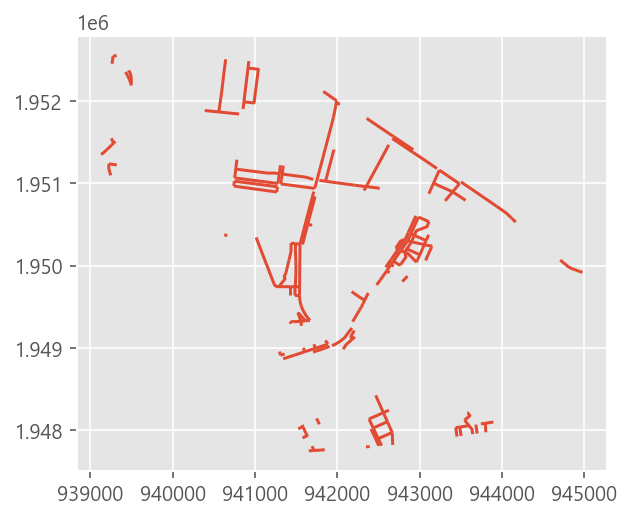

In [328]:
gangseo_bd.plot()

In [313]:
def bd_cal(grid):
    bd_cal_cnt = 0 
    for i in range(len(gangseo_bd['geometry'])):
        if grid.within(gangseo_bd['geometry'][i]) == True:
            bd_cal_cnt +=1
        if grid.crosses(gangseo_bd['geometry'][i])==True:
            bd_cal_cnt+=1
        if grid.intersects(gangseo_bd['geometry'][i]) == True:
            bd_cal_cnt+=1
        else:
            pass
    return bd_cal_cnt

In [329]:
# 격자내에 발달상권 도로가 crosses, intersects, within 인지 확인하기 
# 만약 3개중에 1개라도 1이면 1 
bd_cnt = []
for i in range(len(gangseo_pop_grid['geometry'])):
    bd_cnt.append(bd_cal(gangseo_pop_grid['geometry'][i]))
gangseo_pop_grid['bd_cnt'] = bd_cnt

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

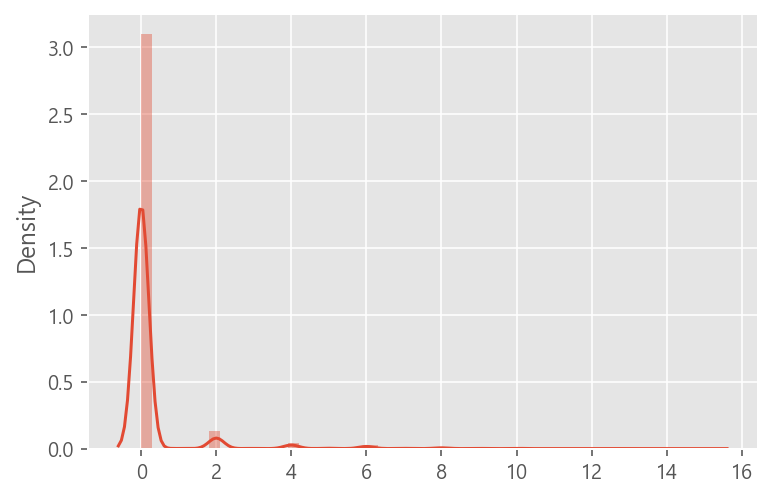

In [343]:
sns.distplot(x=gangseo_pop_grid['bd_cnt'])

In [ ]:
gangseo_pop_grid500m=gangseo_pop_grid.copy()
gangseo_pop_grid500m.geometry=gangseo_pop_grid.geometry.buffer(500).envelop

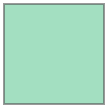

In [371]:
gangseo_pop_grid.geometry.loc[0]

In [372]:
center = [37.541, 126.986]
m = folium.Map(
    location= center,
    zoom_start=10
)
folium.GeoJson(gangseo_pop_grid.geometry.loc[0]).add_to(m) # 1
# 500 
folium.GeoJson(gangseo_pop_grid500m.geometry.loc[0]).add_to(m) # 1

m

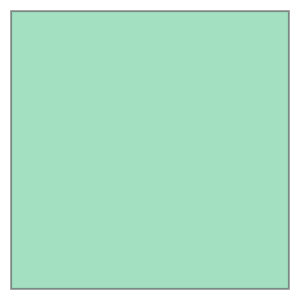

In [368]:
gangseo_pop_grid.geometry.loc[0].buffer(500).envelope

In [358]:

def cal_500(grid1km):
    val500m = 0
    store_cnt500m = 0
    charge_place_cnt500m = 0
    nlimit_charge_place_cnt500m=0
    charge_list_cnt500m = 0
    ncharge_list_cnt500m=0
    predict_elecar500m=0
    for i in range(len(gangseo_pop_grid['geometry'])):
        if gangseo_pop_grid['geometry'][i].within(grid1km)==True:
            
            val500m += gangseo_pop_grid['val'][i]
            store_cnt500m += gangseo_pop_grid['store_cnt'][i]
            charge_place_cnt500m += gangseo_pop_grid['charge_place_cnt'][i]
            nlimit_charge_place_cnt500m += gangseo_pop_grid['nlimit_charge_place_cnt'][i]
            charge_list_cnt500m += gangseo_pop_grid['charge_list_cnt'][i]
            ncharge_list_cnt500m += gangseo_pop_grid['ncharge_list_cnt'][i]
            predict_elecar500m += gangseo_pop_grid['predict_elecar'][i]
        else:
            pass
    km500m={'val500m':val500m, 'store_cnt500m':store_cnt500m, 'charge_place_cnt500m':charge_place_cnt500m, 'nlimit_charge_place_cnt500m':nlimit_charge_place_cnt500m, 
     'charge_list_cnt500m':charge_list_cnt500m, 'ncharge_list_cnt500m':ncharge_list_cnt500m, 'predict_elecar500m':predict_elecar500m}
    return km500m        
    

In [359]:
gangseo_pop_grid500m=gangseo_pop_grid.copy()
gangseo_pop_grid500m.geometry=gangseo_pop_grid.geometry.buffer(500).envelope
km500m_df = pd.DataFrame(columns=['val500m', 'store_cnt500m', 'charge_place_cnt500m', 'nlimit_charge_place_cnt500m',
                               'charge_list_cnt500m', 'ncharge_list_cnt500m', 'predict_elecar500m'])
for i in range(len(gangseo_pop_grid500m['geometry'])):
    km500m_df=km500m_df.append(cal_500(gangseo_pop_grid500m['geometry'][i]), ignore_index=True)
gangseo_pop_grid_500m=pd.concat([gangseo_pop_grid, km500m_df], axis=1)
    

In [360]:

def cal_1km(grid1km):
    val1km = 0
    store_cnt1km = 0
    charge_place_cnt1km = 0
    nlimit_charge_place_cnt1km=0
    charge_list_cnt1km = 0
    ncharge_list_cnt1km=0
    predict_elecar1km=0
    for i in range(len(gangseo_pop_grid['geometry'])):
        if gangseo_pop_grid['geometry'][i].within(grid1km)==True:
            
            val1km += gangseo_pop_grid['val'][i]
            store_cnt1km += gangseo_pop_grid['store_cnt'][i]
            charge_place_cnt1km += gangseo_pop_grid['charge_place_cnt'][i]
            nlimit_charge_place_cnt1km += gangseo_pop_grid['nlimit_charge_place_cnt'][i]
            charge_list_cnt1km += gangseo_pop_grid['charge_list_cnt'][i]
            ncharge_list_cnt1km += gangseo_pop_grid['ncharge_list_cnt'][i]
            predict_elecar1km += gangseo_pop_grid['predict_elecar'][i]
        else:
            pass
    km1={'val1km':val1km, 'store_cnt1km':store_cnt1km, 'charge_place_cnt1km':charge_place_cnt1km, 'nlimit_charge_place_cnt1km':nlimit_charge_place_cnt1km, 
     'charge_list_cnt1km':charge_list_cnt1km, 'ncharge_list_cnt1km':ncharge_list_cnt1km, 'predict_elecar1km':predict_elecar1km}
    return km1        
    

In [361]:
gangseo_pop_grid1km=gangseo_pop_grid.copy()
gangseo_pop_grid1km.geometry=gangseo_pop_grid.geometry.buffer(1000).envelope
km1_df = pd.DataFrame(columns=['val1km', 'store_cnt1km', 'charge_place_cnt1km', 'nlimit_charge_place_cnt1km',
                               'charge_list_cnt1km', 'ncharge_list_cnt1km', 'predict_elecar1km'])
for i in range(len(gangseo_pop_grid1km['geometry'])):
    km1_df=km1_df.append(cal_1km(gangseo_pop_grid1km['geometry'][i]), ignore_index=True)
gangseo_final=pd.concat([gangseo_pop_grid_500m, km1_df], axis=1)
    

In [362]:
gangseo_final.set_geometry(col='geometry', inplace=True)

In [398]:
gangseo_final.columns

Index(['gid', 'lbl', 'val', 'store_cnt', 'charge_pla', 'nlimit_cha',
       'charge_lis', 'ncharge_li', 'light', 'hdong', 'elecar_pop',
       'predict_el', 'near_dist', 'nlimit_nea', 'traffic', 'bd_cnt', 'val500m',
       'store_cnt5', 'charge_p_1', 'nlimit_c_1', 'charge_l_1', 'ncharge__1',
       'predict__1', 'val1km', 'store_cnt1', 'charge_p_2', 'nlimit_c_2',
       'charge_l_2', 'ncharge__2', 'predict__2', 'geometry'],
      dtype='object')

In [364]:
gangseo_final.to_file('data\\savefile\\gangseo_final.shp', encoding='cp949')

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [468]:
gangseo_final=gpd.read_file('data/savefile/gangseo_final.shp', encoding='cp949')


In [532]:
I = gangseo_final[gangseo_final['charge_p_1']>0].reset_index(drop=True) # 수요후보지
J = gangseo_final[gangseo_final['store_cnt5'] > 1146].reset_index(drop=True) # 설치 위치

In [533]:
gangseo_final1 = gangseo_final[gangseo_final['charge_p_1'] > 0].reset_index(drop=True) # 설치 위치

In [534]:
gangseo_final1['score'] = gangseo_final1['predict__1']*0.3 +  gangseo_final1['predict_el']*0.7 + gangseo_final1['bd_cnt'] + gangseo_final1['store_cnt1'] + gangseo_final1['traffic']
score = gangseo_final1['score'].values.tolist()


In [535]:
nlimit_cha_list = gangseo_final1['nlimit_c_1'].values.tolist()

In [536]:
def full_dist_cal(I, J):
    dlist_set = []
    for j in range(len(J)): # 수요지 순서대로 돌아서
        pt = I['geometry'][i]
        dlist_set.append(pt.distance(J['geometry'][j]))
    return dlist_set

# 거리를 재는 함수
# 수요 노드 i에서 설치 후보 노드 j 까지의 거리를 리스트로 반환

In [537]:
fulldlist_set = []

for i in range(len(I)):
    fulldlist_set.append(full_dist_cal(I, J))

In [538]:
I = [i for i in range(len(I))] # 후보지(수요지)
J = [j for j in range(len(J))] # 설치 수 

S = 0.01

N = [[j for j in J if fulldlist_set[i][j] < S ] for i in I]


In [559]:
P = 80

In [560]:
Plist = [10, 20, 30, 40, 50, 60, 70, 80]

In [561]:
prob = LpProblem("MCLP", LpMaximize)

x = LpVariable.dicts('x', J, lowBound=0, upBound=1, cat="Integer") # 설치 후보지 
y = LpVariable.dicts('y', I, lowBound=0, upBound=1, cat="Integer") # 수요지 중에 설치할지

# 목적함수  
prob += lpSum([score[i] + y[i] for i in I])

# 제약식
for i in I:
    if nlimit_cha_list[i] !=0: # 격자 내에 접근 제한이 없는 충전소가 없으면면 수식에 계산 
        prob += lpSum([x[j] for j in N[i]]) >= y[i]


prob += lpSum([x[j] for j in J]) == P
prob.solve()


# x_soln = np.array([x[j].varValue for j in J])

x_soln = np.array([x[j].varValue for j in J])

# And print some output
print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("x = ", x_soln)


Status: Optimal
Population Served is =  43632102.30000006
x =  [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 

In [562]:
idx = np.where(x_soln > 0.0)[0].tolist()

In [563]:
P80_1km=idx

In [564]:
A = gangseo_final[gangseo_final['charge_p_1']>0].reset_index(drop=True) # 수요후보지
B = gangseo_final[gangseo_final['store_cnt1'] > 220].reset_index(drop=True) # 설치 위치
result20 = B.iloc[idx,:]


C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


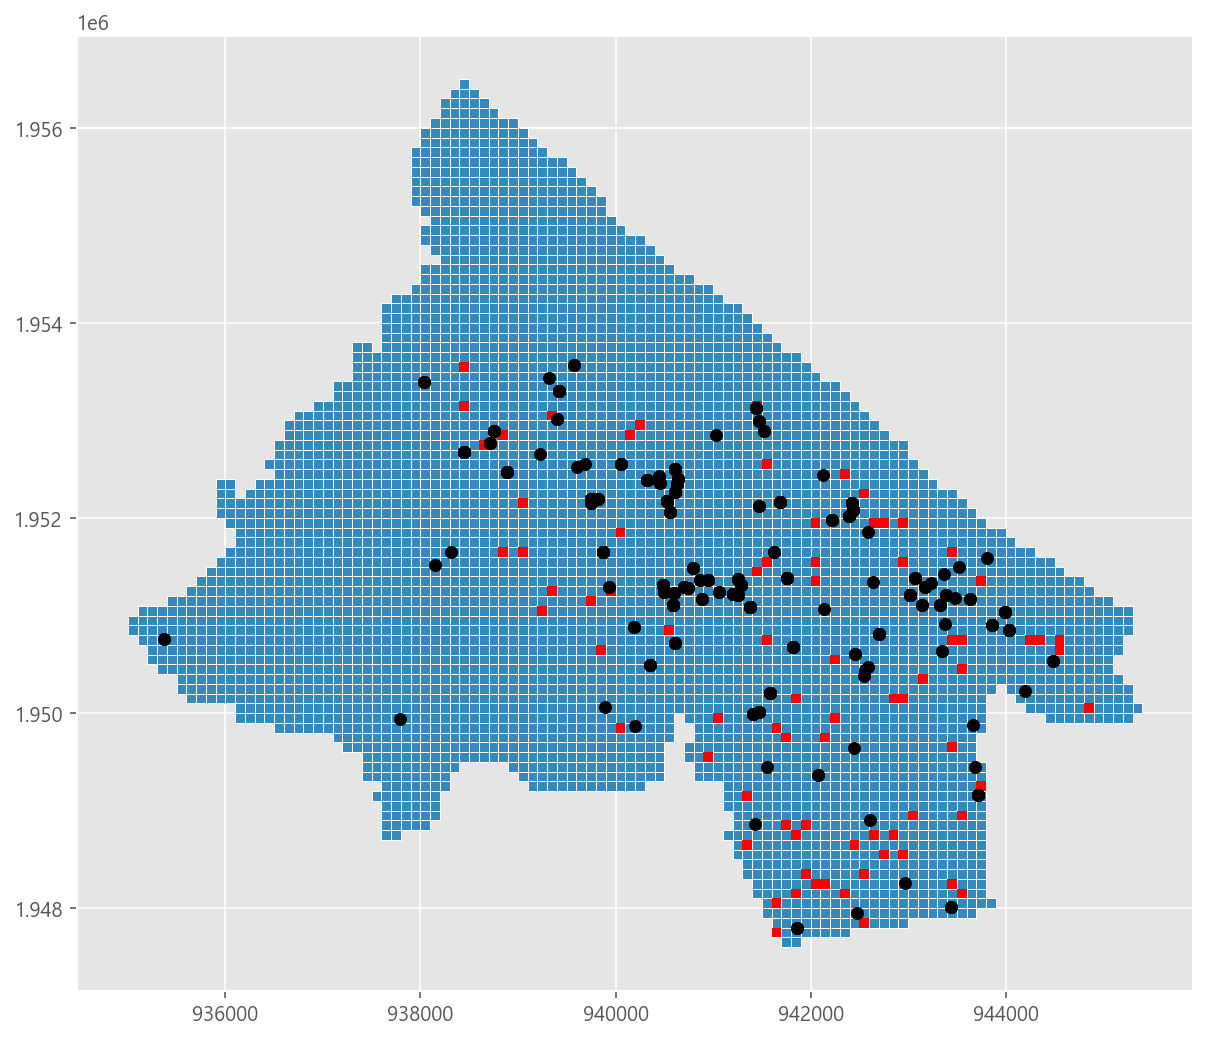

In [565]:
# result20=result20.to_crs({'init':'epsg:4236'})
# gangseo_final = gangseo_final.to_crs({'init':'epsg:4326'})
gdf1=gdf1.to_crs({'init':'epsg:5179'})
ax = gangseo_final.plot(edgecolor='white', figsize=(10, 10))
result20.plot(color = 'red', ax = ax)
gdf1.plot(color='black', ax = ax)
plt.show()

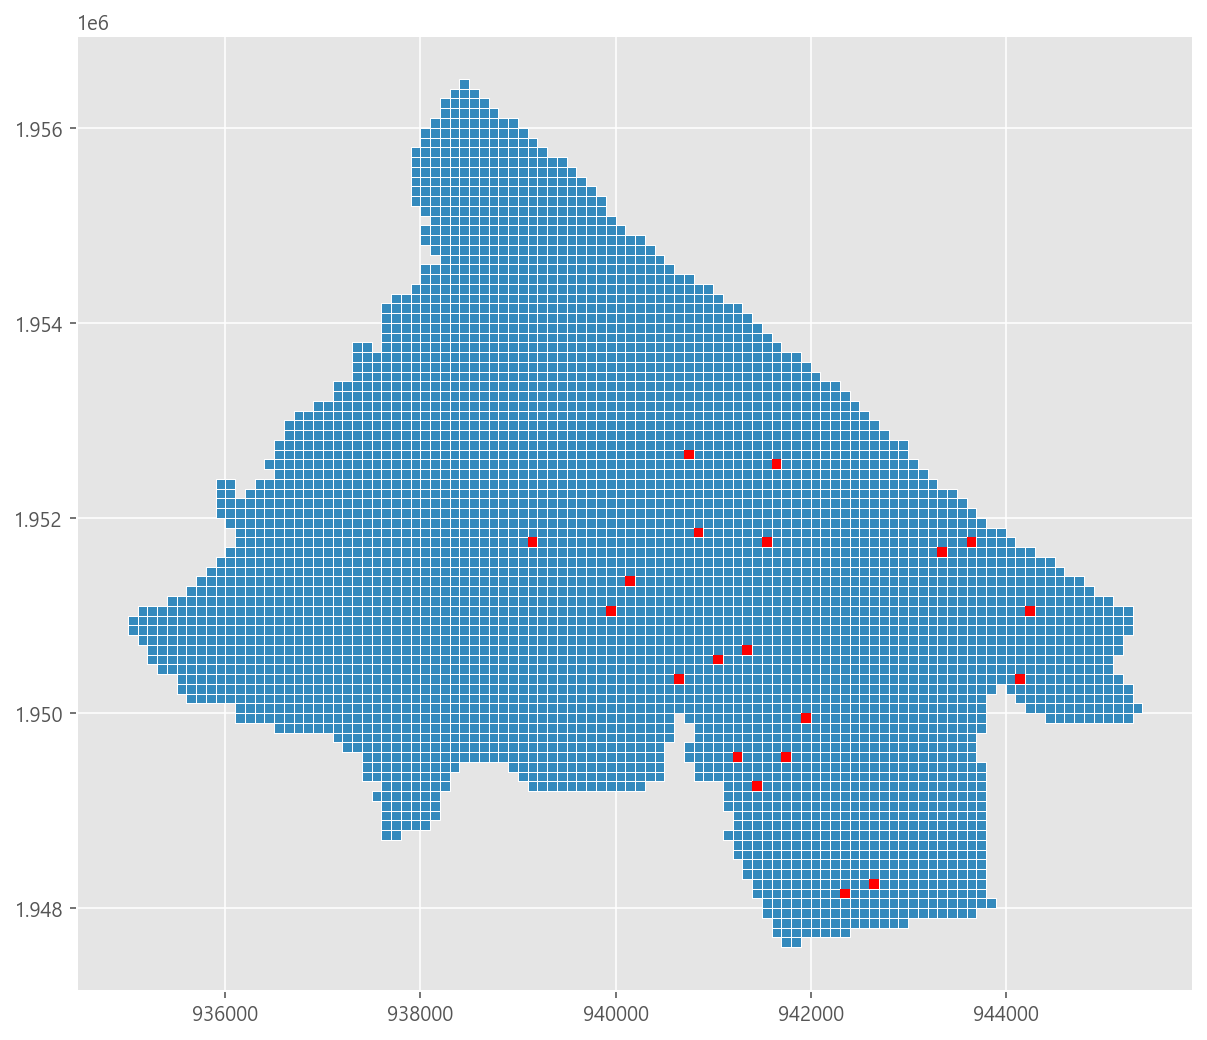

In [434]:
ax = gangseo_final.plot(edgecolor='white', figsize=(10, 10))
result20.plot(color = 'red', ax = ax)

plt.show()

In [571]:
P1km = (P20_1km + P40_1km + P60_1km + P80_1km)

In [572]:
P500m=(P20_500m+P40_500m+P60_500m+P80_500m)

In [628]:
Pfullkmm = (P20_500m+P40_500m+P60_500m+P80_500m + P20_1km + P40_1km + P60_1km + P80_1km)

In [630]:
countsfull = {}
for i in Pfullkmm:
    try: countsfull[i] +=1
    except: countsfull[i]=1
print(countsfull)

{41: 4, 128: 1, 143: 1, 218: 2, 317: 1, 398: 1, 547: 1, 582: 1, 687: 1, 858: 1, 1064: 1, 1284: 2, 1298: 1, 1378: 1, 1584: 2, 1859: 1, 1869: 1, 1931: 1, 1947: 1, 2164: 1, 74: 1, 116: 1, 141: 1, 250: 1, 313: 1, 331: 2, 348: 1, 350: 1, 402: 1, 448: 1, 530: 1, 596: 1, 598: 1, 690: 1, 927: 1, 1007: 1, 1030: 1, 1031: 1, 1059: 1, 1125: 1, 1195: 1, 1241: 1, 1260: 1, 1286: 1, 1326: 1, 1338: 1, 1379: 1, 1412: 1, 1449: 2, 1514: 1, 1537: 1, 1542: 1, 1566: 1, 1605: 1, 1609: 1, 1633: 1, 1634: 1, 1652: 2, 1733: 1, 1908: 1, 0: 1, 30: 1, 43: 1, 60: 1, 71: 2, 118: 1, 175: 1, 186: 3, 208: 1, 219: 1, 270: 1, 393: 1, 537: 1, 567: 1, 569: 2, 571: 1, 580: 1, 711: 1, 724: 1, 807: 1, 816: 1, 839: 1, 885: 1, 895: 1, 972: 1, 973: 1, 985: 1, 998: 1, 1032: 1, 1074: 1, 1094: 1, 1098: 1, 1144: 1, 1160: 1, 1174: 1, 1222: 1, 1223: 1, 1336: 1, 1363: 1, 1373: 1, 1544: 1, 1593: 1, 1602: 1, 1645: 1, 1671: 1, 1674: 1, 1769: 1, 1830: 1, 1857: 2, 1942: 1, 1955: 1, 1956: 1, 2020: 1, 2071: 1, 2175: 1, 2176: 1, 12: 1, 29: 4, 59

In [593]:
counts500 = {}
for i in P500m:
    try: counts500[i] +=1
    except: counts500[i]=1
print(counts500)

{41: 1, 128: 1, 143: 1, 218: 1, 317: 1, 398: 1, 547: 1, 582: 1, 687: 1, 858: 1, 1064: 1, 1284: 2, 1298: 1, 1378: 1, 1584: 2, 1859: 1, 1869: 1, 1931: 1, 1947: 1, 2164: 1, 74: 1, 116: 1, 141: 1, 250: 1, 313: 1, 331: 2, 348: 1, 350: 1, 402: 1, 448: 1, 530: 1, 596: 1, 598: 1, 690: 1, 927: 1, 1007: 1, 1030: 1, 1031: 1, 1059: 1, 1125: 1, 1195: 1, 1241: 1, 1260: 1, 1286: 1, 1326: 1, 1338: 1, 1379: 1, 1412: 1, 1449: 2, 1514: 1, 1537: 1, 1542: 1, 1566: 1, 1605: 1, 1609: 1, 1633: 1, 1634: 1, 1652: 2, 1733: 1, 1908: 1, 0: 1, 30: 1, 43: 1, 60: 1, 71: 2, 118: 1, 175: 1, 186: 1, 208: 1, 219: 1, 270: 1, 393: 1, 537: 1, 567: 1, 569: 2, 571: 1, 580: 1, 711: 1, 724: 1, 807: 1, 816: 1, 839: 1, 885: 1, 895: 1, 972: 1, 973: 1, 985: 1, 998: 1, 1032: 1, 1074: 1, 1094: 1, 1098: 1, 1144: 1, 1160: 1, 1174: 1, 1222: 1, 1223: 1, 1336: 1, 1363: 1, 1373: 1, 1544: 1, 1593: 1, 1602: 1, 1645: 1, 1671: 1, 1674: 1, 1769: 1, 1830: 1, 1857: 2, 1942: 1, 1955: 1, 1956: 1, 2020: 1, 2071: 1, 2175: 1, 2176: 1, 12: 1, 29: 1, 59

In [631]:
countsfull = sorted(countsfull.items(), key = lambda x : x[1], reverse=True)

In [594]:
counts500=sorted(counts500.items(), key = lambda x : x[1], reverse=True)



In [627]:
countsfull

[]

In [645]:
countsfulls= []
for i in countsfull:
    if i[1]>3:
        countsfulls.append(i[0])
    else:
        pass

In [646]:
countsfulls

[41, 29, 140, 236]

In [638]:
cnt_max_1_list = []
for i in counts1:
    if i[1] >3:
        cnt_max_1_list.append(i[0])
    else:
        pass

In [609]:
cnt_max_1_list

[140,
 236,
 61,
 176,
 202,
 272,
 303,
 3,
 7,
 11,
 21,
 29,
 31,
 41,
 73,
 81,
 98,
 108,
 110,
 136,
 147,
 157,
 171,
 177,
 178,
 231,
 285,
 286]

In [651]:
countsfulls

[41, 29, 140, 236]

In [654]:
# within을 사용해서 행정동경계에 grid가 포함되면 소속 행정동 반환
def pop_grid_hdong(grid):
    for i in range(len(gangseo_boundary['geometry'])):
        if grid.within(gangseo_boundary['geometry'][i]) == True:
            hdong_name = gangseo_boundary['adm_nm'][i]
            return hdong_name
        else:
            pass
        
h_counts_fulls = B.iloc[countsfulls,:]
grid_hdong = []
for i in range(len(gangseo_pop_grid['geometry'])): 
    grid_in_hdong=pop_grid_hdong(gangseo_pop_grid['geometry'][i])
    grid_hdong.append(grid_in_hdong)
gangseo_pop_grid['hdong'] = grid_hdong

In [655]:
grid_hdong = []
for i in range(len(h_counts_fulls['geometry'])):
    grid_in_full_hdong = pop_grid_hdong(h_counts_fulls['geometry'][i])
    grid_hdong.append(grid_in_full_hdong)

KeyError: 0

In [647]:
A = gangseo_final[gangseo_final['charge_p_1']>0].reset_index(drop=True) # 수요후보지
B = gangseo_final[gangseo_final['store_cnt1'] > 220].reset_index(drop=True) # 설치 위치
result20 = B.iloc[countsfulls,:]


C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


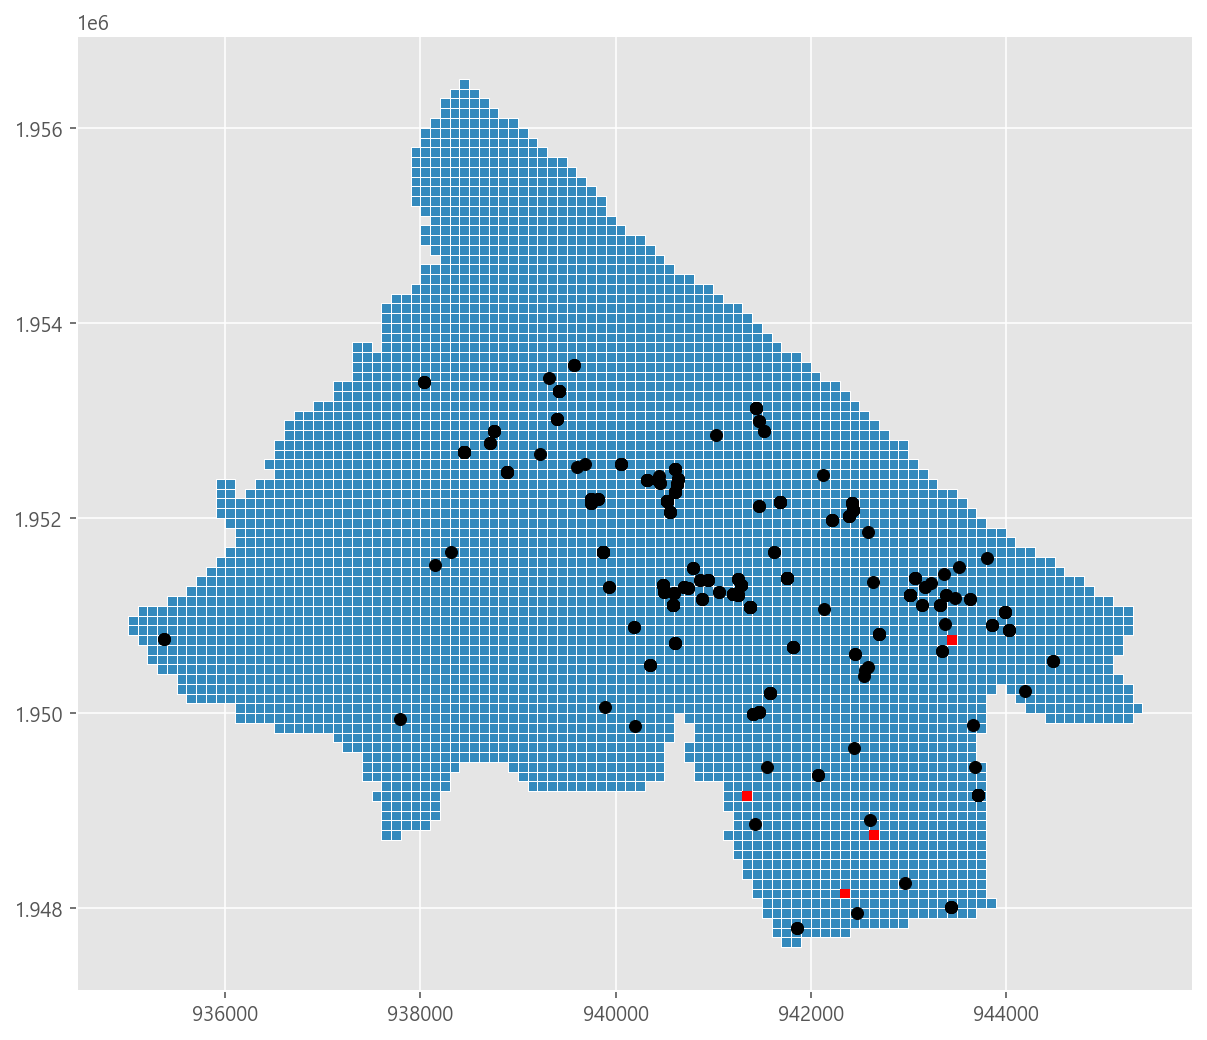

In [648]:
# result20=result20.to_crs({'init':'epsg:4236'})
# gangseo_final = gangseo_final.to_crs({'init':'epsg:4326'})
gdf1=gdf1.to_crs({'init':'epsg:5179'})
ax = gangseo_final.plot(edgecolor='white', figsize=(10, 10))
result20.plot(color = 'red', ax = ax)
gdf1.plot(color='black', ax = ax)
plt.show()

In [596]:
cnt_max_1_list

[140,
 236,
 61,
 176,
 202,
 272,
 303,
 3,
 7,
 11,
 21,
 29,
 31,
 41,
 73,
 81,
 98,
 108,
 110,
 136,
 147,
 157,
 171,
 177,
 178,
 231,
 285,
 286]

In [601]:
cnt_max_500_list

[1284, 1584, 331, 1449, 1652, 71, 569, 1857]

In [566]:
P80_1km

[3,
 7,
 11,
 18,
 19,
 21,
 25,
 26,
 27,
 29,
 31,
 35,
 41,
 44,
 46,
 49,
 54,
 56,
 57,
 59,
 61,
 64,
 69,
 73,
 78,
 81,
 91,
 92,
 93,
 97,
 98,
 100,
 108,
 110,
 125,
 129,
 132,
 135,
 136,
 137,
 138,
 139,
 140,
 144,
 147,
 157,
 159,
 161,
 171,
 174,
 176,
 177,
 178,
 184,
 195,
 198,
 202,
 203,
 209,
 214,
 224,
 227,
 231,
 234,
 236,
 249,
 259,
 261,
 264,
 268,
 269,
 272,
 276,
 277,
 279,
 281,
 285,
 286,
 291,
 303]

In [427]:
chargelist_gangseo = pd.read_csv('data/gangseo_charge_list.csv', encoding='cp949')
chargelist_gangseo.drop(['Unnamed: 0'], axis = 1, inplace = True)
chargelist_gangseo.head(3)

,운영기관,충전소,충전기ID,충전기타입,지역,시군구,주소,이용가능시간,이용자 제한,급속충전량,비고,위도,경도,구역행정동
0,환경부(한국자동차환경협회),가로공원로 지하공영주차장,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 가로공원로 189 지하주차장 05,24시간 이용가능,NaN,급속(50kW),주차요금 별도,37.537235,126.837039,강서구 화곡1동
1,환경부(한국자동차환경협회),가양레포츠센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 양천로61길 101,24시간 이용가능,NaN,급속(100kW멀티),NaN,37.561985,126.863732,강서구 가양3동
2,환경부(한국자동차환경협회),강서구민올림픽체육센터,1,DC차데모+AC3상+DC콤보,서울특별시,강서구,서울특별시 강서구 화곡로65길62,06:00~22:00,NaN,급속(100kW멀티),시설공단 요청사항,37.559670,126.850584,강서구 등촌3동


In [428]:
chargelist_gangseo['이용자 제한'] = chargelist_gangseo['이용자 제한'].fillna('n')
chargelist_gangseo['제한여부'] = np.where(chargelist_gangseo['이용자 제한']== 'n', 'N', 'Y')
chargelist_gangseo.tail(3)
chargelist_gangseo_rest_Y = chargelist_gangseo[chargelist_gangseo['제한여부']=='Y']
chargelist_gangseo_rest_N = chargelist_gangseo[chargelist_gangseo['제한여부']=='N']


In [429]:
# charge_pt = gpd.points_from_xy(chargelist_gangseo_rest_Y.경도, chargelist_gangseo_rest_Y.위도)
# charge_pt = gpd.points_from_xy(chargelist_gangseo_rest_Y['경도'], chargelist_gangseo_rest_Y['위도'])
charge_pt = gpd.points_from_xy(chargelist_gangseo_rest_N.경도, chargelist_gangseo_rest_N.위도)
# 좌표계 정의/변환용 라이브러리
import pyproj
from fiona.crs import from_epsg

gdf1 = gpd.GeoDataFrame(geometry=charge_pt, crs=from_epsg(4326))
#df1_gdf.info()
gdf1.head()



C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,POINT (126.83704 37.53723)
1,POINT (126.86373 37.56198)
2,POINT (126.85058 37.55967)
3,POINT (126.84890 37.52906)
4,POINT (126.80157 37.56214)


In [438]:
result20.crs

<Projected CRS: EPSG:5179>
Name: Korea 2000 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Geocentric datum of Korea
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


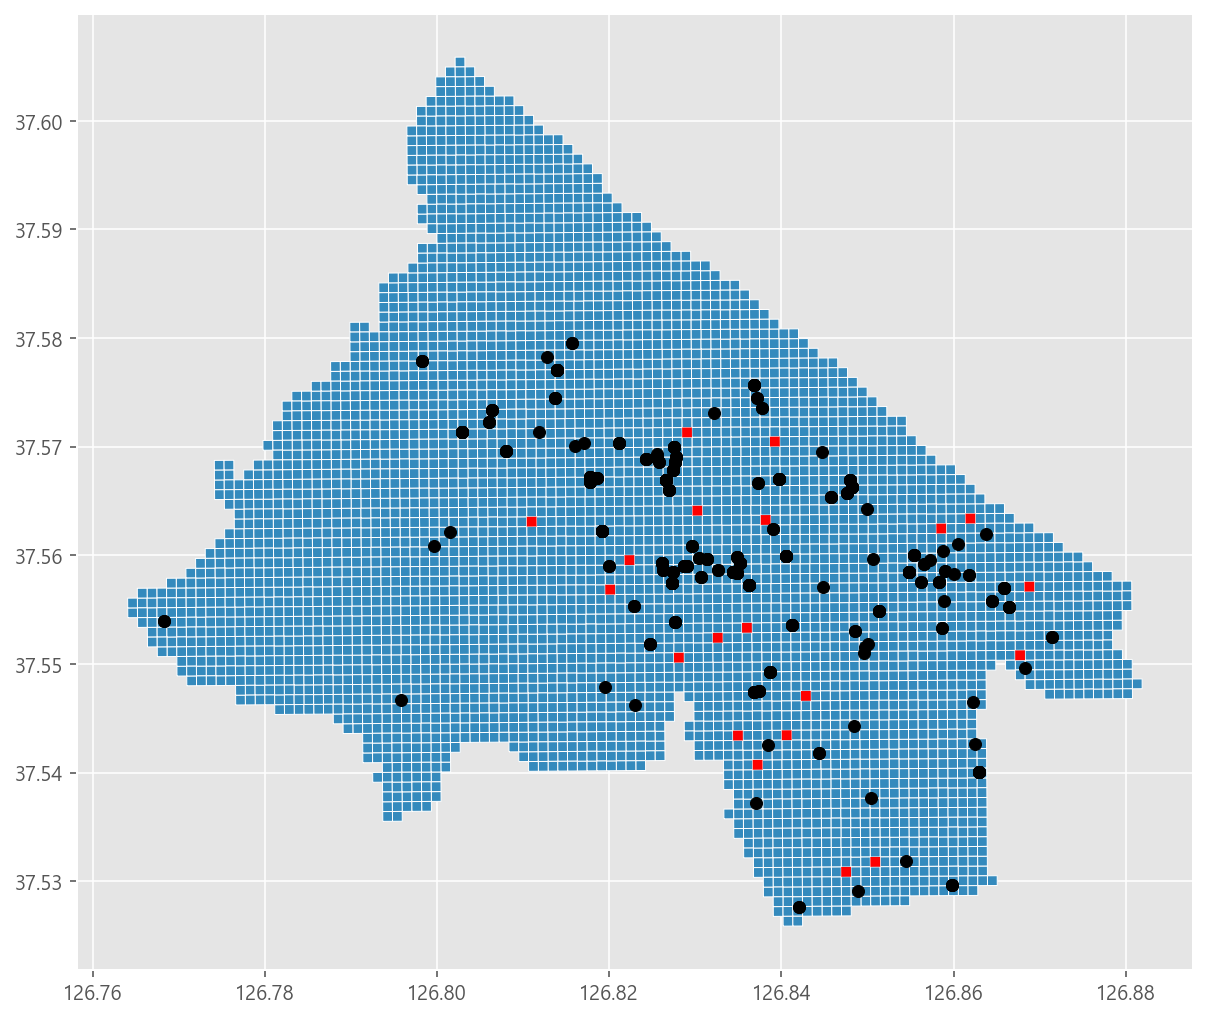

In [445]:
result20=result20.to_crs({'init':'epsg:4236'})
gangseo_final = gangseo_final.to_crs({'init':'epsg:4326'})
ax = gangseo_final.plot(edgecolor='white', figsize=(10, 10))
result20.plot(color = 'red', ax = ax)
gdf1.plot(color='black', ax = ax)
plt.show()

In [416]:
import numpy as np

In [391]:
gangseo_final.columns

Index(['gid', 'lbl', 'val', 'store_cnt', 'charge_pla', 'nlimit_cha',
       'charge_lis', 'ncharge_li', 'light', 'hdong', 'elecar_pop',
       'predict_el', 'near_dist', 'nlimit_nea', 'traffic', 'bd_cnt', 'val500m',
       'store_cnt5', 'charge_p_1', 'nlimit_c_1', 'charge_l_1', 'ncharge__1',
       'predict__1', 'val1km', 'store_cnt1', 'charge_p_2', 'nlimit_c_2',
       'charge_l_2', 'ncharge__2', 'predict__2', 'geometry'],
      dtype='object')

In [393]:
gangseo_final['store_cnt5'].describe()

count    4382.000000
mean      410.569375
std       451.292159
min         0.000000
25%         6.000000
50%       219.500000
75%       781.000000
max      2011.000000
Name: store_cnt5, dtype: float64

In [482]:
from pulp import *


In [529]:
len(I)

2557

In [ ]:
dlistIJ = []
for i in range(len(I)):
    for j in range(len(J)):
        

In [527]:
I = gangseo_final[gangseo_final['store_cnt1km'] > 50].reset_index(drop=True)
J = gangseo_final[gangseo_final['light']>0].reset_index(drop=True)

In [484]:
"""
I = 수요지점 세트 # 설치 가능한 격자
J = 시설입지 세트 # 설치가 필요한 격자 
S = 수요지를 커버할 수 있는 거리 # 0.01 = 위경도 1km
dij : 수요 포인트 i 와 시설물 입지 후보지 j와의 거리   # 
ai = i지점의 서비스 수요 # ai 계산해서 예측 
P = 설치예정인 시설물 수 #
Ni = 수요지를 커버할 수 있는 시설후보지 집합 
yi = 1: 수요지점 i에 최소 한개의 시설물로 커버되는 경우 
     0: 그렇지 않은 경우
xj = 1: 시설물이 j에 할당된 경우
     0 : 그렇지 않은 경우
"""

SyntaxError: invalid syntax (2362687299.py, line 1)

In [686]:
I = gangseo_final[gangseo_final['store_cnt1km'] > 50].reset_index(drop=True)
J = gangseo_final[gangseo_final['light']>0].reset_index(drop=True)

In [687]:
def full_dist_cal(I, J):
    dlist_set = []
    for j in range(len(J)): # 수요지 순서대로 돌아서
        pt = J['geometry'][j]
        dlist_set.append(pt.distance(I['geometry'][i]))
    return dlist_set

# 거리를 재는 함수
# 수요 노드 i에서 설치 후보 노드 j 까지의 거리를 리스트로 반환

In [688]:
fulldlist_set = []

for i in range(len(I)):
    fulldlist_set.append(full_dist_cal(I, J))

In [702]:
a = [] 

for i in range(len(I)):
    a.append(round(I.predict_elecar1km[i] / (7*2*4)))

In [708]:
I = [i for i in range(len(I))]
J = [j for j in range(len(J))]

In [709]:
prob = LpProblem('MCLP', LpMaximize)


In [721]:
S = 0.01
N = [[j for j in J if fulldlist_set[i][j] < S] for i in I]


In [722]:
x = LpVariable.dicts('x', J, 0)
y = LpVariable.dicts('y', I, 0)

In [723]:
prob += lpSum([a[i]*y[i] for i in I])

C:\Users\TFG5076XG\anaconda3\envs\gangseo\lib\site-packages\pulp\pulp.py:1704: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


In [724]:
len(a)

2557

In [725]:
len(I)

2557

In [726]:
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

In [739]:
P =100
prob += lpSum([x[j] for j in J]) == P

In [740]:
from pulp import *

In [741]:
prob

MCLP:
MAXIMIZE
80*y_0 + 20*y_1 + 30*y_2 + 0
SUBJECT TO
_C1: x_0 - y_0 >= 0

_C2: x_0 - y_1 >= 0

_C3: x_1 - y_2 >= 0

_C4: x_0 + x_1 = 1

_C5: x_0 + x_1 = 100

VARIABLES
x_0 Continuous
x_1 Continuous
y_0 Continuous
y_1 Continuous
y_2 Continuous

In [742]:
LpSolverDefault.msg = 1

In [22]:
prob.solve()

1

In [25]:
y[1]

y_1

In [26]:
N

[[0], [0], [1]]

In [38]:
gangseo_final

,gid,lbl,val,store_cnt,charge_pla,nlimit_cha,charge_lis,ncharge_li,light,hdong,...,charge_p_1,nlimit_c_1,charge_l_1,ncharge__1,predict__1,geometry,sc1,sc2,sc3,sc4
0,다사404502,289,289,2,2,0,7,0,7,발산1동,...,11.0,3.0,38.0,8.0,65.0,"POLYGON ((126.82528 37.54921, 126.82527 37.550...",1.0,0.727273,1.0,0.789474
1,다사436483,217,217,30,0,0,0,0,1,화곡4동,...,1.0,1.0,4.0,3.0,15.0,"POLYGON ((126.86165 37.53229, 126.86164 37.533...",NaN,0.000000,NaN,0.250000
2,다사391528,46,46,25,0,0,0,0,10,방화1동,...,13.0,8.0,41.0,27.0,98.0,"POLYGON ((126.81035 37.57256, 126.81034 37.573...",NaN,0.384615,NaN,0.341463
3,다사400518,615,615,3,0,0,0,0,1,방화1동,...,25.0,8.0,159.0,42.0,99.0,"POLYGON ((126.82062 37.56361, 126.82061 37.564...",NaN,0.680000,NaN,0.735849
4,다사402503,646,646,3,0,0,0,0,4,발산1동,...,11.0,5.0,37.0,11.0,60.0,"POLYGON ((126.82300 37.55010, 126.82300 37.551...",NaN,0.545455,NaN,0.702703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,다사379488,0,0,0,0,0,0,0,0,공항동,...,0.0,0.0,0.0,0.0,0.0,"POLYGON ((126.79710 37.53643, 126.79709 37.537...",NaN,NaN,NaN,NaN
4378,다사410509,0,0,0,0,0,0,0,4,발산1동,...,25.0,14.0,98.0,59.0,109.0,"POLYGON ((126.83201 37.55556, 126.83200 37.556...",NaN,0.440000,NaN,0.397959
4379,다사378491,0,0,0,0,0,0,0,0,공항동,...,0.0,0.0,0.0,0.0,0.0,"POLYGON ((126.79594 37.53913, 126.79593 37.540...",NaN,NaN,NaN,NaN
4380,다사398539,0,0,0,0,0,0,0,3,방화3동,...,3.0,1.0,6.0,2.0,5.0,"POLYGON ((126.81818 37.58252, 126.81817 37.583...",NaN,0.666667,NaN,0.666667


In [35]:
import numpy as np
import pandas as pd
from pulp import *

# Some dummy data, let's have 3 demand nodes and 2 possible sites
I = [0,1,2]
J = [0,1]
S = 100
d = [[50, 150], [80, 110], [160, 10]]

a = [80, 20, 30]
P = 1

# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node
N = [[j for j in J if d[i][j] < S] for i in I]

# Formulate optimisation

prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts("x", J, 0)
y = LpVariable.dicts("y", I, 0)

# Objective
prob += lpSum([a[i]*y[i] for i in I])

# Constraints
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == P

# # Solve problem
# prob.solve()

# x_soln = np.array([x[j].varValue for j in J])

# # And print some output
# print (("Status:"), LpStatus[prob.status])
# print ("Population Served is = ", value(prob.objective))
# print ("x = ", x_soln)

In [34]:
prob

MCLP:
MAXIMIZE
80*y_0 + 20*y_1 + 30*y_2 + 0
VARIABLES
y_0 Continuous
y_1 Continuous
y_2 Continuous

In [36]:
prob

MCLP:
MAXIMIZE
80*y_0 + 20*y_1 + 30*y_2 + 0
SUBJECT TO
_C1: x_0 - y_0 >= 0

_C2: x_0 - y_1 >= 0

_C3: x_1 - y_2 >= 0

VARIABLES
x_0 Continuous
x_1 Continuous
y_0 Continuous
y_1 Continuous
y_2 Continuous

In [37]:
prob

MCLP:
MAXIMIZE
80*y_0 + 20*y_1 + 30*y_2 + 0
SUBJECT TO
_C1: x_0 - y_0 >= 0

_C2: x_0 - y_1 >= 0

_C3: x_1 - y_2 >= 0

VARIABLES
x_0 Continuous
x_1 Continuous
y_0 Continuous
y_1 Continuous
y_2 Continuous

In [616]:
I = gangseo_final[gangseo_final['light']>0].reset_index(drop=True)
J = gangseo_final[gangseo_final['store_cnt1km'] > 50].reset_index(drop=True)


# def 거리 함수 계산이 들어가고  거리 값을 뽑은 다음에 


I = [i for i in range(len(I))]
J = [j for j in range(len(J))]
S = 0.01
N = [[j for j in J if fulldlist_set[j][i] <S ]for i in I]
# 거리계산한 matrix로 들어가니깐 

In [646]:
import numpy as np
import pandas as pd
from pulp import *

# Some dummy data, let's have 3 demand nodes and 2 possible sites
I = [0,1,2]
J = [0,1]
S = 100
d = [[50, 150], [80, 110], [160, 10]]

a = [80, 20, 30]
P = 1

# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node
N = [[j for j in J if d[i][j] < S] for i in I]

# Formulate optimisation

prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts("x", J, 0)
y = LpVariable.dicts("y", I, 0)

# Objective
prob += lpSum([a[i]*y[i] for i in I])

# Constraints
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == P

# Solve problem
prob.solve()

x_soln = np.array([x[j].varValue for j in J])

# And print some output
print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("x = ", x_soln)

Status: Optimal
Population Served is =  100.0
x =  [1. 0.]


In [621]:
prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts('x', J, 0)
y = LpVariable.dicts('y', I, 0)


In [623]:
prob += lpSum([a[i]*y[i] for i in I])


IndexError: list index out of range

In [614]:
prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts('x', J, 0)
y = LpVariable.dicts('y', I, 0)

prob += lpSum([a[i]*y[i] for i in I])
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >=y[i]

prob += lpSum([x[j] for j in J])==P
prob.solve()


IndexError: list index out of range

In [612]:
cnt = 0
for i in range(len(I)):
    for j in range(len(J)):
        if fulldlist_set[j][i] <S:
            cnt +=1
        else:
            pass 
        
    

In [57]:
def full_dist_cal(I, J):
    dlist_set = []
    for j in range(len(J)): # 수요지 순서대로 돌아서
        pt = J['geometry'][j]
        dlist_set.append(pt.distance(I['geometry'][i]))
    return dlist_set

In [65]:
import numpy as np
import pandas as pd
from pulp import *

# Some dummy data, let's have 3 demand nodes and 2 possible sites
I = gangseo_final[gangseo_final['store_cnt1'] > 50].reset_index(drop=True)
J = gangseo_final[gangseo_final['light']>0].reset_index(drop=True)

d = []

for i in range(len(I)):
    d.append(full_dist_cal(I, J))

a = [] 

for i in range(len(I)):
    a.append(round(I.predict__1[i] / (7*2*4)))
S = 0.01


P = 20

In [66]:
S = 0.01


P = 20

In [69]:
I = [i for i in range(len(I))]
J = [j for j in range(len(J))]

In [72]:


# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node
N = [[j for j in J if d[i][j] < S] for i in I]

# # Formulate optimisation

prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts("x", J, 0)
y = LpVariable.dicts("y", I, 0)

# Objective
prob += lpSum([a[i]*y[i] for i in I])

# Constraints
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == P

# Solve problem
prob.solve()

x_soln = np.array([x[j].varValue for j in J])

# And print some output
print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("x = ", x_soln)

Status: Optimal
Population Served is =  13600.0
x =  [0. 0. 0. ... 0. 0. 0.]


In [138]:
import numpy as np
import pandas as pd
from pulp import *

# Some dummy data, let's have 3 demand nodes and 2 possible sites
I = gangseo_final[gangseo_final['store_cnt1'] > 50].reset_index(drop=True)
J = gangseo_final[gangseo_final['light']>0].reset_index(drop=True)

d = []

for i in range(len(I)):
    d.append(full_dist_cal(I, J))

a = [] 

for i in range(len(I)):
    a.append(round(I.predict__1[i] / (7*2*4)))
S = 0.01


P = 20

In [114]:
S = 0.01

P = 10

In [120]:
I = [i for i in range(len(I))]
J = [j for j in range(len(J))]
N = [[j for j in J if d[i][j] < S] for i in I]

In [121]:
prob = LpProblem("MCLP", LpMaximize)
x = LpVariable.dicts("x", J, 0)
y = LpVariable.dicts("y", I, 0)

In [122]:
prob

MCLP:
MAXIMIZE
None
VARIABLES

In [127]:
a[72]

1

In [112]:
# a[i] = i에 대한 예측 수요량=60이면 * y[0] = y_0 = 60y_0
prob += lpSum([a[i]*y[i] for i in I])

In [130]:
# 
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

In [133]:
prob += lpSum([x[j] for j in J]) == P


In [134]:
prob.solve()

1

In [135]:
x_soln = np.array([x[j].varValue for j in J])

In [136]:
x_soln

array([10.,  0.,  0., ...,  0.,  0.,  0.])

In [139]:
gangseo_final

,gid,lbl,val,store_cnt,charge_pla,nlimit_cha,charge_lis,ncharge_li,light,hdong,...,charge_p_1,nlimit_c_1,charge_l_1,ncharge__1,predict__1,geometry,sc1,sc2,sc3,sc4
0,다사404502,289,289,2,2,0,7,0,7,발산1동,...,11.0,3.0,38.0,8.0,65.0,"POLYGON ((126.82528 37.54921, 126.82527 37.550...",1.0,0.727273,1.0,0.789474
1,다사436483,217,217,30,0,0,0,0,1,화곡4동,...,1.0,1.0,4.0,3.0,15.0,"POLYGON ((126.86165 37.53229, 126.86164 37.533...",NaN,0.000000,NaN,0.250000
2,다사391528,46,46,25,0,0,0,0,10,방화1동,...,13.0,8.0,41.0,27.0,98.0,"POLYGON ((126.81035 37.57256, 126.81034 37.573...",NaN,0.384615,NaN,0.341463
3,다사400518,615,615,3,0,0,0,0,1,방화1동,...,25.0,8.0,159.0,42.0,99.0,"POLYGON ((126.82062 37.56361, 126.82061 37.564...",NaN,0.680000,NaN,0.735849
4,다사402503,646,646,3,0,0,0,0,4,발산1동,...,11.0,5.0,37.0,11.0,60.0,"POLYGON ((126.82300 37.55010, 126.82300 37.551...",NaN,0.545455,NaN,0.702703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,다사379488,0,0,0,0,0,0,0,0,공항동,...,0.0,0.0,0.0,0.0,0.0,"POLYGON ((126.79710 37.53643, 126.79709 37.537...",NaN,NaN,NaN,NaN
4378,다사410509,0,0,0,0,0,0,0,4,발산1동,...,25.0,14.0,98.0,59.0,109.0,"POLYGON ((126.83201 37.55556, 126.83200 37.556...",NaN,0.440000,NaN,0.397959
4379,다사378491,0,0,0,0,0,0,0,0,공항동,...,0.0,0.0,0.0,0.0,0.0,"POLYGON ((126.79594 37.53913, 126.79593 37.540...",NaN,NaN,NaN,NaN
4380,다사398539,0,0,0,0,0,0,0,3,방화3동,...,3.0,1.0,6.0,2.0,5.0,"POLYGON ((126.81818 37.58252, 126.81817 37.583...",NaN,0.666667,NaN,0.666667


In [88]:
x_soln.sum()

20.0

In [ ]:
x

In [62]:
I.columns

Index(['gid', 'lbl', 'val', 'store_cnt', 'charge_pla', 'nlimit_cha',
       'charge_lis', 'ncharge_li', 'light', 'hdong', 'elecar_pop',
       'predict_el', 'near_dist', 'nlimit_nea', 'cctv_cnt', 'traffic',
       'bd_cnt', 'val1km', 'store_cnt1', 'charge_p_1', 'nlimit_c_1',
       'charge_l_1', 'ncharge__1', 'predict__1', 'geometry', 'sc1', 'sc2',
       'sc3', 'sc4'],
      dtype='object')